<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<font size="5"><b><center>Yandex Hackathon: EDA by Team № 4</center></b></font>

# Загрузка библиотек

In [5]:
import numpy as np
import pandas as pd
import os

from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm, notebook

import warnings

warnings.filterwarnings("ignore")
notebook.tqdm().pandas()

0it [00:00, ?it/s]

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.width', 1000)

In [7]:
cwd = os.getcwd()

In [8]:
PATH_DATA = cwd + '/initial_data/data.csv'
PATH_SKU = cwd + '/initial_data/sku.csv'
PATH_SKU_CARGOTYPES = cwd + '/initial_data/sku_cargotypes.csv'
PATH_CARTON = cwd + '/initial_data/carton.csv'
PATH_CARGOTYPES_INFO = cwd + '/initial_data/cargotype_info.csv'
PATH_CARTON_PRICE = cwd + '/initial_data/carton_price.xlsx'

# Знакомство с данными

In [9]:
data = pd.read_csv(PATH_DATA, index_col=0)

**<u>Описание данных:</u>**

- whs - код сортировочного центра;
- orderkey - id заказа;
- selected_cartontype - код упаковки, которая была выбрана пользователем;
- box_num - количество коробок;
- recommended_cartontype - код упаковки, рекомендованной алгоритмом;
- selected_carton - код упаковки, которая была выбрана пользователем (дубль);
- sel_calc_cube - объём выбранной упаковки;
- recommended_carton - код упаковки, рекомендованной алгоритмом (дубль);
- pack_volume - рассчитанный объём упакованных товаров;
- **rec_calc_cube - (?)**
- goods_wght - вес товара;
- sku - id товара;
- who - упаковщик;
- trackingid - id доставки;

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325623 entries, 0 to 325622
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   whs                     325623 non-null  int64  
 1   orderkey                325623 non-null  object 
 2   selected_cartontype     325623 non-null  object 
 3   box_num                 325623 non-null  int64  
 4   recommended_cartontype  325623 non-null  object 
 5   selected_carton         325623 non-null  object 
 6   sel_calc_cube           325623 non-null  int64  
 7   recommended_carton      325623 non-null  object 
 8   pack_volume             325623 non-null  int64  
 9   rec_calc_cube           325623 non-null  int64  
 10  goods_wght              325623 non-null  float64
 11  sku                     325623 non-null  object 
 12  who                     325623 non-null  object 
 13  trackingid              325623 non-null  object 
dtypes: float64(1), int64

In [11]:
data.describe()

,whs,box_num,sel_calc_cube,pack_volume,rec_calc_cube,goods_wght
count,325623.000000,325623.000000,325623.000000,3.256230e+05,325623.000000,325623.000000
mean,1.366166,2.787773,11188.402656,5.440790e+03,18253.646168,1.134705
std,2.098641,15.774209,13958.516542,2.858190e+04,26745.365119,4.090043
min,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,1.000000,3449.000000,5.000000e+02,3449.000000,0.110000
50%,0.000000,1.000000,8436.000000,1.192000e+03,8525.000000,0.300000
75%,3.000000,1.000000,15579.000000,3.154000e+03,18270.000000,0.799000
max,7.000000,235.000000,108000.000000,1.815450e+06,108000.000000,153.700000


In [12]:
data.head()

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid
0,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
1,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
2,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
3,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
4,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24


# Исследовательский анализ данных

**<u>Функции для исследования</u>**

In [13]:
def plot_boxplot(df, column, x_min, x_max):
    '''Строит боксплот с границами размаха усов.
       Примает на вход датасет, имя признака, и параметры для масштабирования оси X'''
    outliers, left_border, right_border = get_outliers(df, column)

    plt.figure(figsize=(15, 5))
    plt.title(f'Boxplot для "{column}"', fontsize=17)
    sns.set_style('darkgrid')
    sns.boxplot(data = df[column], color='lightblue', orient="h", showcaps=False, notch=True,
                medianprops={"color": "red"}, boxprops=dict(alpha=.5))
    left_border_line = plt.axvline(left_border, color='g', linestyle=':',
                                   label='Левая граница')
    right_border_line = plt.axvline(right_border, color='g', linestyle='-.', 
                                    label='Правая граница')
    plt.text((left_border), ( 0 - 0.5), 
             f'Левая граница {left_border:.2f}', color='green', fontsize=14)
    plt.text((right_border + 0.5), ( 0 - 0.3), 
             f'Правая граница {right_border:.2f}', color='green', fontsize=14) 
    plt.xlabel('Значения', fontsize=14)
    plt.xlim(x_min, x_max)
    plt.legend(edgecolor = 'r',
               facecolor = 'oldlace')
    plt.grid(True); 

In [14]:
def get_outliers(df, column):
    '''Принимает на вход датасет и имя признака и вовращает выбросы, а также левую и правую границу размаха усов BOXPLOT'''
    q_one = df[column].quantile(q=.25)
    q_three  = df[column].quantile(q=.75)
    iqr = q_three - q_one
    left_border = q_one-(1.5*iqr)
    right_border = q_three+(1.5*iqr)
    outliers_left = df[df[column] < left_border]
    outliers_right = df[df[column] > right_border]
    full_outliers = len(outliers_left) + len(outliers_right)
    return(full_outliers, left_border, right_border)

In [15]:
def plot_charts(df, df_columns):
    '''Рисует графики BOXPLOT и HIST для колонки(feature) Датасета.
       На вход принимает датасет и список c именами колонок'''
    df = df
    num_chrt = len(df_columns)
    for column in df_columns:   
        fig = plt.figure(figsize=[20, 7])
        grd = plt.GridSpec(ncols=1,nrows=2, top=0.92, wspace=0.15, hspace=0)
        plt.suptitle(f"COLUMN № {column}", fontsize=15)
        fig_ax_1 = fig.add_subplot(grd[1,0])
        plt.grid(True)
        sns.set_style('darkgrid')
        sns.histplot(df[column])
        plt.axvline(np.mean(df[column]), 
                    color='r', 
                    linestyle='--',
                    label='MEAN')
        plt.axvline(np.median(df[column]), 
                    color='green', 
                    linestyle='--',
                    label='MEDIAN')
        plt.xlabel('Value', fontsize=13)
        fig_ax_2 = fig.add_subplot(grd[0,0])
        sns.set_style('darkgrid')
        plt.grid(True)
        boxplot = plt.boxplot(df[column].values, vert=False, meanline=True, showmeans=True, notch=True, patch_artist=True)
        outliers = list(boxplot['fliers'][0].get_data()[1])
        plt.axvline(np.mean(df[column]), 
                    color='r', 
                    linestyle='--',
                    label='MEAN')
        plt.axvline(np.median(df[column]), 
                    color='green', 
                    linestyle='--',
                    label='MEDIAN')
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.legend(title=f"MEAN = {np.mean(df[column]):.2f}, MEDIAN={np.median(df[column]):.2f}, OUTLIERS={len(outliers)}, STD={df[column].std():.2f}",
                   edgecolor = 'r',
                   facecolor = 'oldlace',
                   ncol=2,
                   title_fontsize=15,
                   fontsize=15);

In [16]:
def plot_two_boxplot(first_col, second_col):
    """Рисует boxplot для двух указаных колонок датасета data с целью сравненния.
       На вход принимает имена колонок"""
    plt.figure(figsize=(15, 7))
    plt.title(f'Boxplot для {first_col} и {second_col}', fontsize=17)
    sns.set_style('darkgrid')
    sns.boxplot(data = data[[first_col, second_col]], palette=['red', 'lightblue'], orient="h", showcaps=False, notch=True, medianprops={"color": "red"}, boxprops=dict(alpha=.5))
    plt.ylabel('"Рекомендовано алгоритмом" и "Выбранно упаковщиком"', fontsize=15)
    plt.xlabel('Значения', fontsize=14)
    plt.grid(True);

In [17]:
def str_to_lower(df):
    '''Переводит все текстовые значения датасета в нижний регистр.
       На вход принимает датасет'''
    for column in df.columns:
        if (df[column].dtype == 'object'):
            df[column] = df[column].str.lower()
    return df

**Сразу изменим регистр на нижний всех текстовых значений датасета data для удобства.**

In [18]:
data = str_to_lower(data)

## Сортировочный центр

**Посмотрим на распределение значений сортировочных центров**

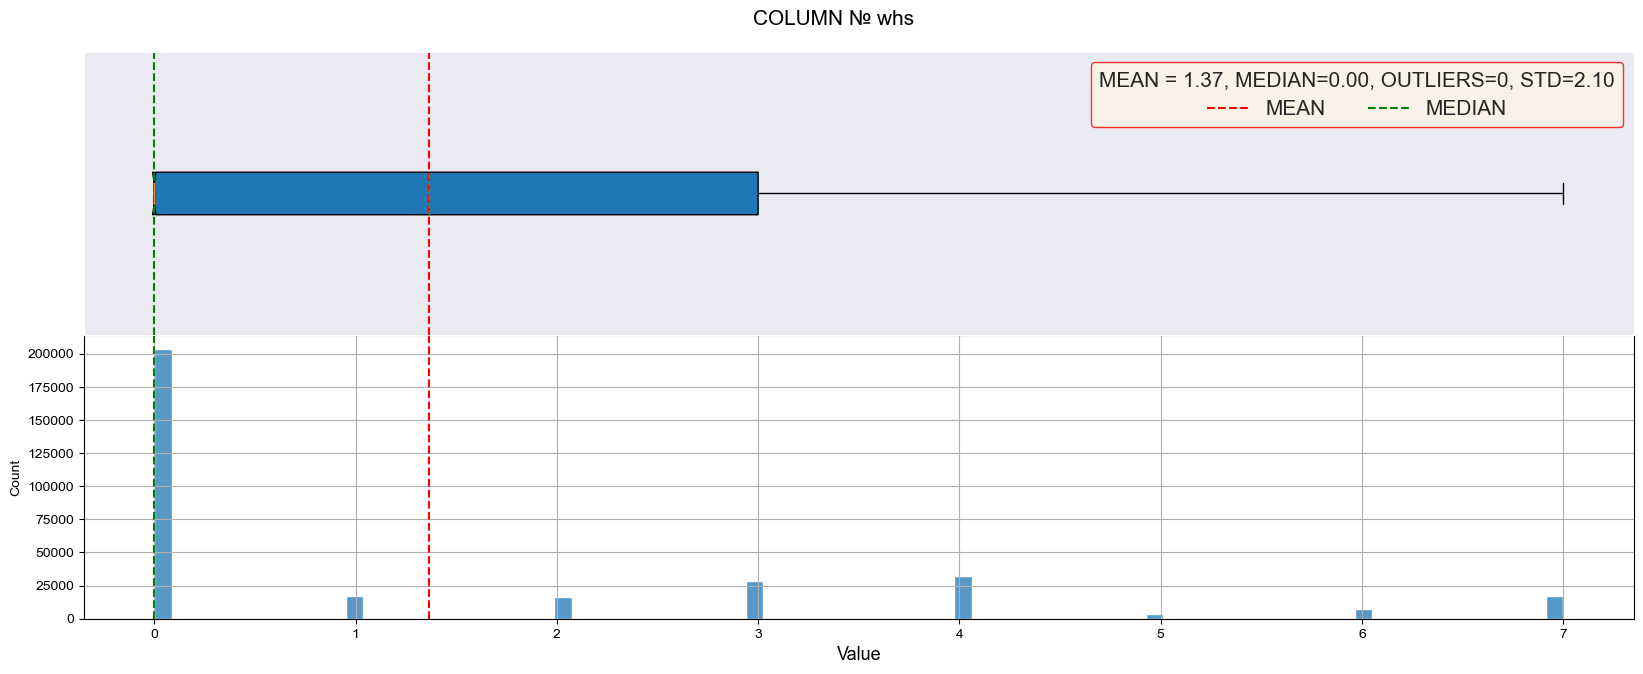

In [19]:
plot_charts(data, ['whs'])

**На графике видно, что у сортировочного центра со значением 0 нагрузка выше чем у остальных.Вполне возможно, что он находится в крупном городе/транспортном узле.Мы считаем, что для будущей прогнастической модели признак "Сортировочный центр" значения иметь не будет, поэтому от него избавимся на этапе предобработки данных.**

## Товар

### Габариты

**Для анализа весогабаритных характеристик потребуется открыть и присоединить таблицу с товарами.**

In [20]:
sku = pd.read_csv(PATH_SKU, index_col=0)

**<u>Описание габаритов товара:</u>**

- sku - id товара
- a, b, c, - размеры

In [21]:
sku.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6385961 entries, 0 to 6385960
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   sku     object 
 1   a       float64
 2   b       float64
 3   c       float64
dtypes: float64(3), object(1)
memory usage: 243.6+ MB


In [22]:
sku.head()

,sku,a,b,c
0,8ba57dcdba9a58b0c4edd180bef6afc9,11.0,31.0,28.0
1,d9af6ce6f9e303f4b1a8cb47cde21975,29.0,14.0,40.0
2,8b91fd242bde88f0891380506d9c3caa,12.0,13.0,35.0
3,e8af308a7659e34194770d1e3a48e144,3.0,13.0,8.0
4,dc0e2542e122731217289b8e6d3bd3f8,96.0,18.0,56.0


In [23]:
sku.describe()

,a,b,c
count,6.385961e+06,6.385961e+06,6.385961e+06
mean,2.108468e+01,1.203353e+01,1.782524e+01
std,1.890676e+01,1.487745e+01,1.508838e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+01,3.000000e+00,8.000000e+00
50%,1.800000e+01,8.000000e+00,1.500000e+01
75%,2.800000e+01,1.600000e+01,2.400000e+01
max,6.554000e+03,2.050000e+03,5.930000e+02


**По данным видно, что некоторые габариты имеют нулевое значение, значит для данных товаров нет сведений об их размерах, если данный признак будет использоваться при обучении, то необходимо будет решить вопрос с заполнением нулей. Во время обучения его возможно потребуется удалить.**

**Поскольку размеры в таблице записаны случайно, то для анализа запишем их в список, отсортируем и вернём от меньшего к большему**

In [24]:
sku['list_demensions'] = sku.progress_apply(lambda x: sorted([x['a'], x['b'], x['c']]), axis=1)

  0%|          | 0/6385961 [00:00<?, ?it/s]

In [25]:
sku['a'] = sku.progress_apply(lambda x: x['list_demensions'][0], axis=1)
sku['b'] = sku.progress_apply(lambda x: x['list_demensions'][1], axis=1)
sku['c'] = sku.progress_apply(lambda x: x['list_demensions'][2], axis=1)

  0%|          | 0/6385961 [00:00<?, ?it/s]

  0%|          | 0/6385961 [00:00<?, ?it/s]

  0%|          | 0/6385961 [00:00<?, ?it/s]

In [26]:
sku.describe()

,a,b,c
count,6.385961e+06,6.385961e+06,6.385961e+06
mean,7.735032e+00,1.704490e+01,2.616352e+01
std,8.330654e+00,1.317235e+01,2.087516e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,9.000000e+00,1.500000e+01
50%,5.000000e+00,1.400000e+01,2.200000e+01
75%,1.000000e+01,2.200000e+01,3.100000e+01
max,5.000000e+02,5.000000e+02,6.554000e+03


**Построим гистограммы распределения для габаритов**

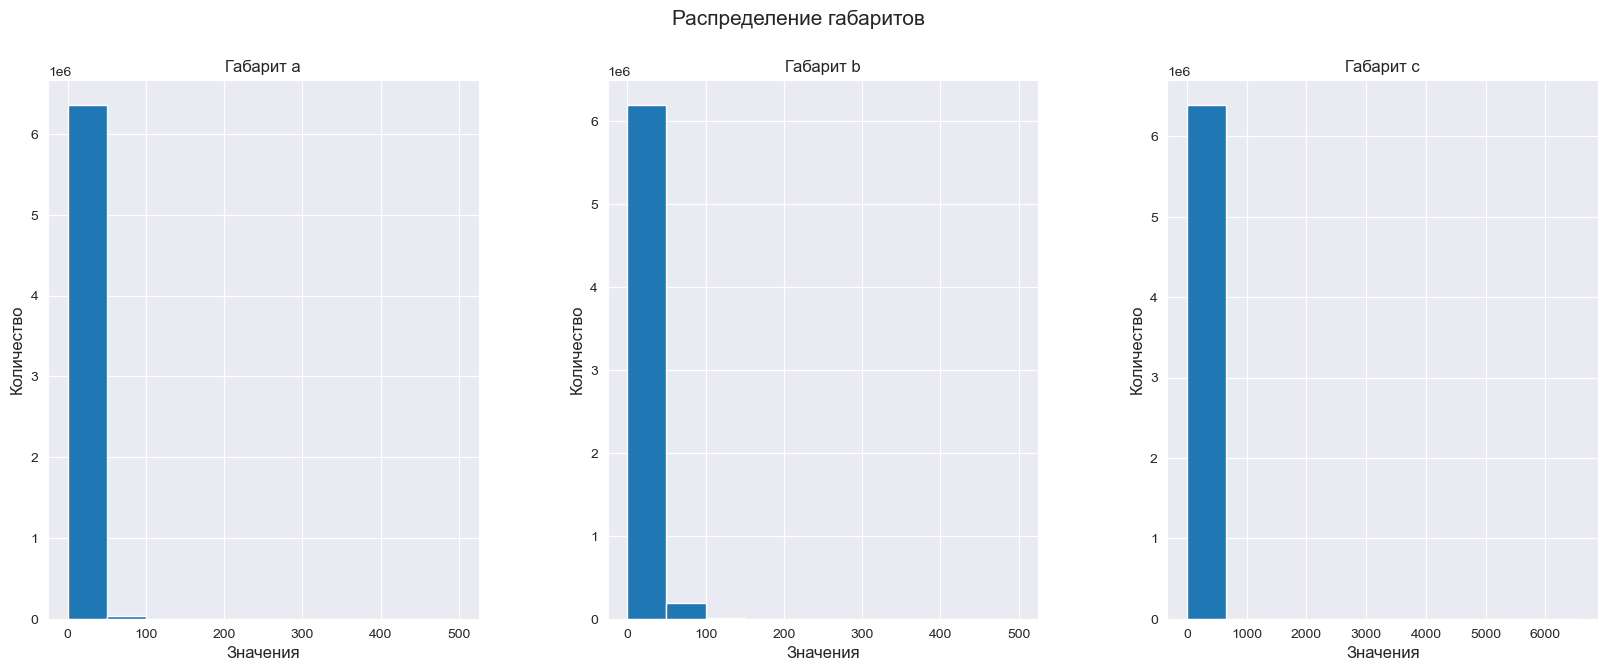

In [27]:
plt.figure(figsize=[20, 7])
plt.subplots_adjust(top=0.88, wspace=0.3, hspace=0.98)
sns.set_style('darkgrid')
plt.suptitle('Распределение габаритов', fontsize=15)
plt.subplot(1, 3, 1)
plt.title('Габарит a', fontsize=12)
sku['a'].hist()
plt.ylabel('Количество', fontsize=12)
plt.xlabel('Значения', fontsize=12)
plt.subplot(1, 3, 2)
plt.title('Габарит b', fontsize=12)
sku['b'].hist()
plt.ylabel('Количество', fontsize=12)
plt.xlabel('Значения', fontsize=12)
plt.subplot(1, 3, 3)
plt.title('Габарит c', fontsize=12)
sku['c'].hist()
plt.ylabel('Количество', fontsize=12)
plt.xlabel('Значения', fontsize=12)
plt.show(True);

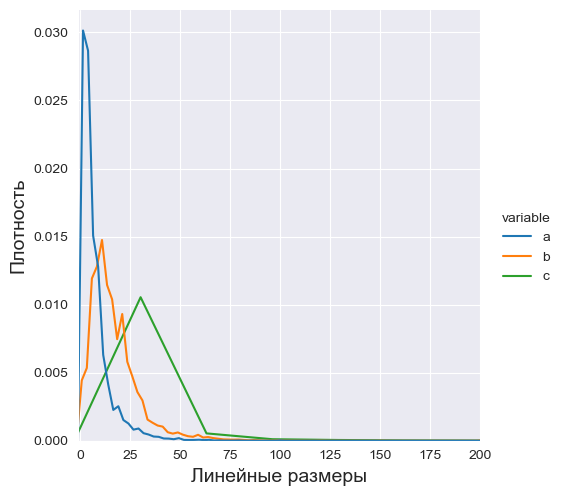

In [23]:
sns.set_style('darkgrid')
sns.displot(pd.melt(sku, id_vars=['sku'], value_vars=['a', 'b', 'c']), x='value', hue='variable', kind='kde')
plt.ylabel('Плотность', fontsize=14)
plt.xlim(-1, 200)
plt.xlabel('Линейные размеры', fontsize=14)
plt.grid(True);

**Товары а таблице SKU уникальны. Нет одних и тех же товаров с разными размерами. Во всех габаритных размерах присутствуют выбросы по максимальному габариту есть значение больше 6000**

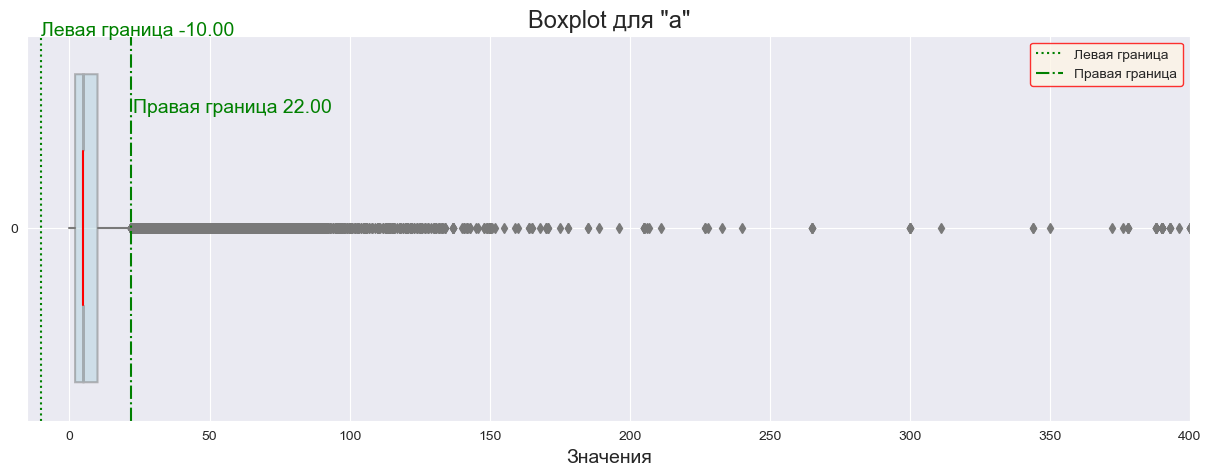

In [24]:
plot_boxplot(sku, 'a', -15, 400)

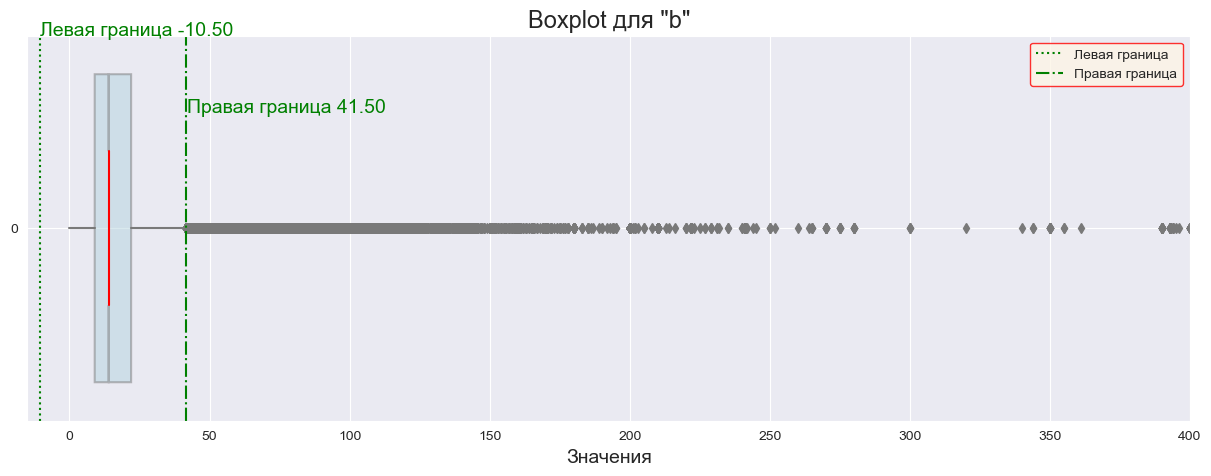

In [25]:
plot_boxplot(sku, 'b', -15, 400)

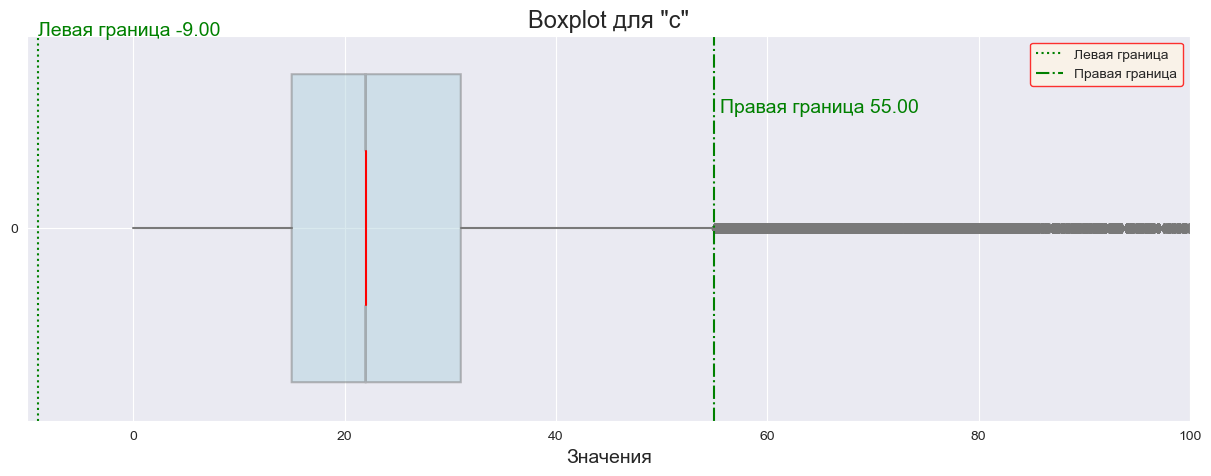

In [26]:
plot_boxplot(sku, 'c', -10, 100)

**На графиках видно, что в данные присутствуют аномалиии. Для улучшения модели качества в дальнейшем от них избавимся.**

In [27]:
print('Процент товаров, которые имеют 0 габарит =', sku[sku['a']==0]['a'].count() / sku.shape[0] * 100)

Процент товаров, которые имеют 0 габарит = 4.245610018601742


In [28]:
data = data.merge(sku, how='left', on='sku')

**Посмотрим все ли значения присоеденились.**

In [29]:
print('Количество пропусков после присоединения -', data.isna().sum())

Количество пропусков после присоединения - whs                           0
orderkey                      0
selected_cartontype           0
box_num                       0
recommended_cartontype        0
selected_carton               0
sel_calc_cube                 0
recommended_carton            0
pack_volume                   0
rec_calc_cube                 0
goods_wght                    0
sku                           0
who                           0
trackingid                    0
a                         10793
b                         10793
c                         10793
list_demensions           10793
dtype: int64


In [30]:
data[data['a'].isna()]

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid,a,b,c,list_demensions
203777,1,5d7baab1dcf5ba49b97516ff16467396,myb,1,mya,myb,3449,mya,144,999,0.15,33ba558d53dd1a7a96c31aed029f9ed3,5137f94d8773f0931c97685d650e1638,98df738cd66c6093996093be86a23d7c,NaN,NaN,NaN,NaN
203826,1,afdf747ad65b3cdd9f3c7797c1cb0b8e,myb,1,myb,myb,3449,myb,180,3449,0.05,4c4ac3712e772845fba89ce68f4412c1,cd9f603b16c4df1e9e17c0c6071565a4,6c360099ce2c50db0f0c6e07e9ccbdee,NaN,NaN,NaN,NaN
203827,1,afdf747ad65b3cdd9f3c7797c1cb0b8e,myb,1,myb,myb,3449,myb,60,3449,0.01,cd3b7ad7ae84f0df849176899e94cf73,cd9f603b16c4df1e9e17c0c6071565a4,6c360099ce2c50db0f0c6e07e9ccbdee,NaN,NaN,NaN,NaN
203938,1,7277dc63455a66fc1f464676ec673f60,myc,1,yma,myc,8436,yma,1500,4068,0.55,6774be38b29817785e93573d76844df3,73376f6665e6fec8192823467094c1c4,2980e8d6a1404e1f43c6150cd04b0d40,NaN,NaN,NaN,NaN
203939,1,7277dc63455a66fc1f464676ec673f60,myc,1,yma,myc,8436,yma,1500,4068,0.55,6774be38b29817785e93573d76844df3,73376f6665e6fec8192823467094c1c4,2980e8d6a1404e1f43c6150cd04b0d40,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325555,7,a59faf61238504e1d016bdbbcfc021f3,nonpack,4,nonpack,nonpack,0,nonpack,91476,0,59.72,13ba70bed14a8fd7dcc4d0824eb47c14,027659f40187d994e0254a043e56aee7,0d1c64093532e59f3c670378576fb8a5,NaN,NaN,NaN,NaN
325561,7,75fb032affb232cad3adf2a7aba9b4a5,nonpack,2,nonpack,nonpack,0,nonpack,59940,0,42.68,cea20aa2522b9174903ce5295d0cda94,772e05546251e3616e46b1822c6538aa,2eb78b6ab8837b033351d8846b75267d,NaN,NaN,NaN,NaN
325596,7,c222a91f0e96b7e5da99196b9cee1e8f,nonpack,1,nonpack,nonpack,0,nonpack,62500,0,58.14,bf7a3a70807e105a0234edece79f5508,eeafb158c529eaf1aa9b8f2068a82914,00ec60fb840b20442a0283aff3760fa5,NaN,NaN,NaN,NaN
325601,7,2526e186f56a90cc9f77a7bdd72a3064,nonpack,1,nonpack,nonpack,0,nonpack,59940,0,42.68,cea20aa2522b9174903ce5295d0cda94,772e05546251e3616e46b1822c6538aa,f89237f7cedc633ea3093744c84781f6,NaN,NaN,NaN,NaN


**Как видим в данных есть несоответствие между двумя таблицами и не для всех значений всё смёржилось.**

**Посмотрим попали ли товары с нулевым габаритом в выборку, и если попали, то сколько процентов**

In [31]:
print('Процент товаров с нулевым габаритами -', data[data['a']==0]['a'].count() / data.shape[0] * 100)

Процент товаров с нулевым габаритами - 0.03255298305095156


**Таки строк менее 0,03 процента. Выведем такие строки**

In [32]:
data[data['a']==0]

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid,a,b,c,list_demensions
21620,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.000,c67f783f0901454a55318fc3be3b6421,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"
21621,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.000,c67f783f0901454a55318fc3be3b6421,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"
21622,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.000,c67f783f0901454a55318fc3be3b6421,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"
21623,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.000,c67f783f0901454a55318fc3be3b6421,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"
21624,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.000,c67f783f0901454a55318fc3be3b6421,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"
21625,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.000,5bc9da3b9043c46d999af2d3da73b4cd,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"
21626,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.000,5bc9da3b9043c46d999af2d3da73b4cd,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"
21627,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.000,5bc9da3b9043c46d999af2d3da73b4cd,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"
21628,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.000,5bc9da3b9043c46d999af2d3da73b4cd,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"
21629,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.000,5bc9da3b9043c46d999af2d3da73b4cd,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"


**По данным можно предположить, что товары с нулевыми габаритами и нулевым весом упаковываются в YMF, проверим это**

In [33]:
data[(data['a']==0) & (data['goods_wght']==0)]

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid,a,b,c,list_demensions
21620,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,c67f783f0901454a55318fc3be3b6421,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"
21621,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,c67f783f0901454a55318fc3be3b6421,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"
21622,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,c67f783f0901454a55318fc3be3b6421,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"
21623,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,c67f783f0901454a55318fc3be3b6421,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"
21624,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,c67f783f0901454a55318fc3be3b6421,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"
21625,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,5bc9da3b9043c46d999af2d3da73b4cd,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"
21626,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,5bc9da3b9043c46d999af2d3da73b4cd,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"
21627,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,5bc9da3b9043c46d999af2d3da73b4cd,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"
21628,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,5bc9da3b9043c46d999af2d3da73b4cd,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"
21629,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,5bc9da3b9043c46d999af2d3da73b4cd,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]"


In [34]:
data[(data['a']==0) & (data['goods_wght']==0)]['selected_cartontype'].value_counts()

yma        18
ymf        12
myb         8
stretch     5
ymw         2
yml         2
Name: selected_cartontype, dtype: int64

**Предположение оказалось не верным, возможно что-то ещё влияет на выбор упаковки для таких товаров.**
**Посмотрим различается ли медианное значение по упоковкам для минимального и максимального габарита**

In [35]:
pivot_df = data.pivot_table(index='selected_carton', values=['a', 'c'], aggfunc='median')

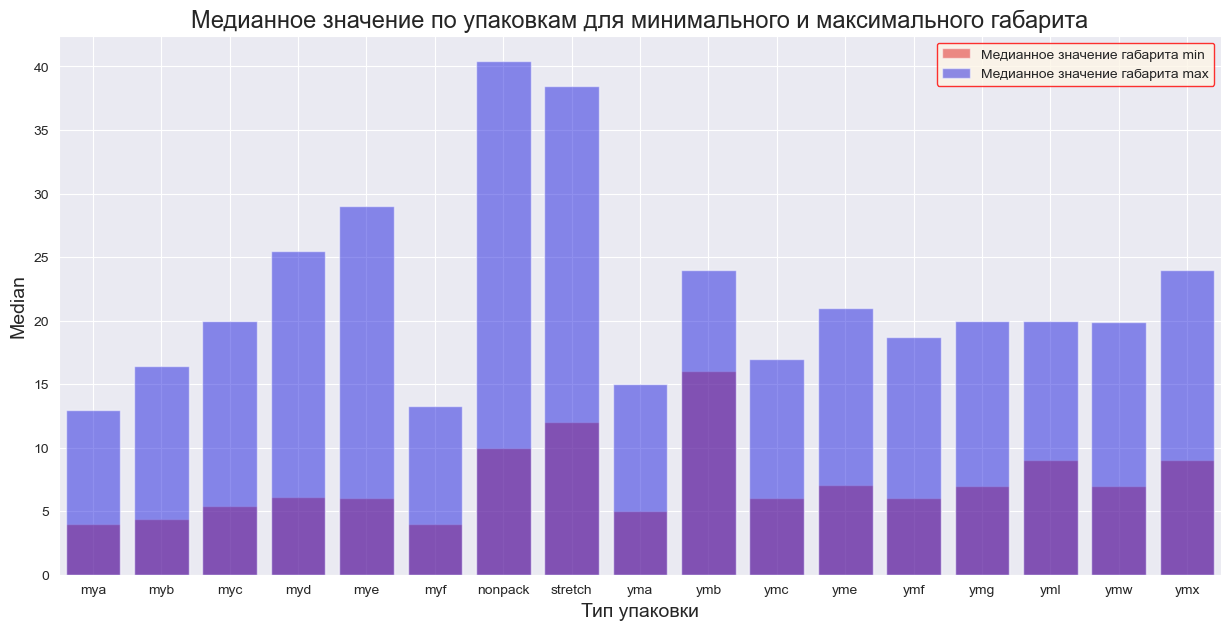

In [36]:
plt.figure(figsize=(15, 7))
plt.title('Медианное значение по упаковкам для минимального и максимального габарита', fontsize=17)
sns.set_style('darkgrid')
sns.barplot(data=pivot_df,
            x=pivot_df.index,
            y='a',
            color='red',
            alpha=0.5,
            label = 'Медианное значение габарита min')
sns.barplot(data=pivot_df,
            x=pivot_df.index,
            y='c',
            alpha=0.5,
            color='blue',
            label = 'Медианное значение габарита max')
plt.ylabel('Median', fontsize=14)
plt.xlabel('Тип упаковки', fontsize=14)
plt.grid(True)
plt.legend(edgecolor = 'r',
           facecolor = 'oldlace');

**Из графика видно, что большие изделия чаще имеют упаковку NONPACK и STRETCH так что эти признаки могут помочь модели обучиться.**

### Карготипы

In [37]:
sku_cargotypes = pd.read_csv(PATH_SKU_CARGOTYPES, index_col=0)

**<u>Описание карготипа товара:</u>**

- sku - id товара
- cargotype - карготип товара


In [38]:
sku_cargotypes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21053152 entries, 0 to 21053151
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   sku        object
 1   cargotype  int64 
dtypes: int64(1), object(1)
memory usage: 481.9+ MB


In [39]:
sku_cargotypes.head()

,sku,cargotype
0,4862bf0e760a593b13f3f2fcf822e533,290
1,4862bf0e760a593b13f3f2fcf822e533,901
2,50d3c4fc66ad423b7feaadff2d682ee0,290
3,50d3c4fc66ad423b7feaadff2d682ee0,901
4,24ce9dba9f301ada55f60e25ee1498d2,290


**Изучим карготипы товаров**

In [40]:
sku_cargotypes['cargotype'] = sku_cargotypes['cargotype'].astype('str') 

**Всего 88 штук, при этом некоторые очень распространены, другие встречаются в единице случаев.**

**Рассмотрим сколько карготипов имеет один товар.**

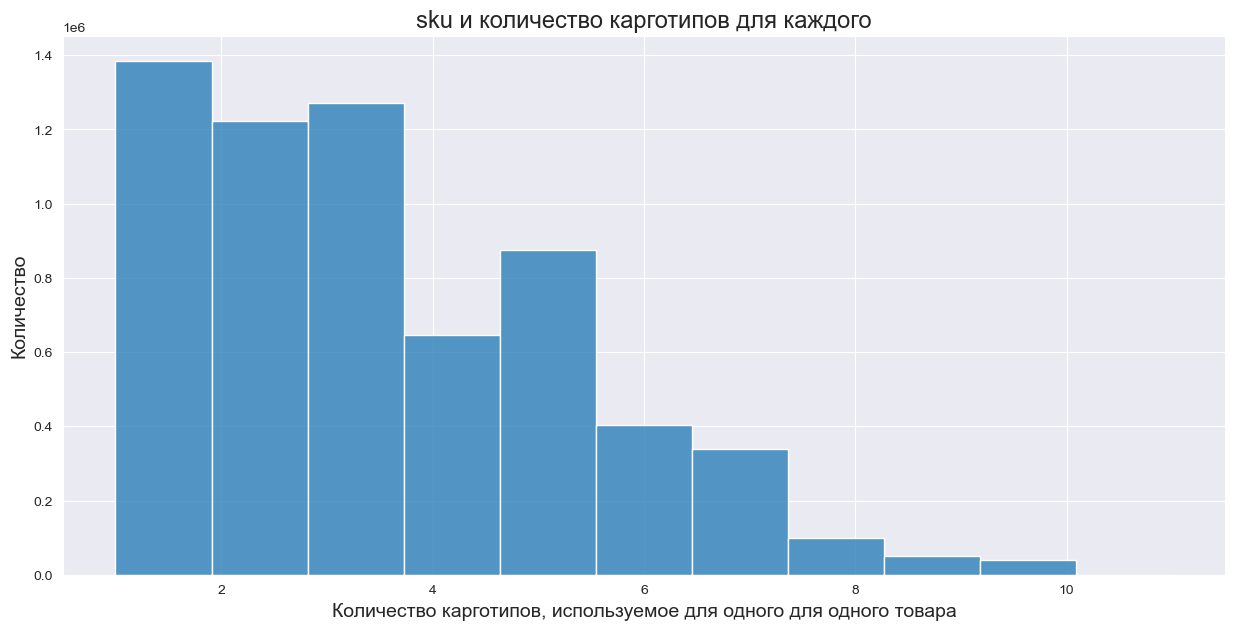

In [41]:
df_num_cargotype_with_sku = sku_cargotypes.pivot_table(index='sku', values='cargotype', aggfunc='count').reset_index()
plt.figure(figsize=(15, 7))
plt.title('sku и количество карготипов для каждого', fontsize=17)
sns.set_style('darkgrid')
sns.histplot(df_num_cargotype_with_sku['cargotype'],
             bins = df_num_cargotype_with_sku['cargotype'].max())
plt.ylabel('Количество', fontsize=14)
plt.xlabel('Количество карготипов, используемое для одного для одного товара', fontsize=14)
plt.grid(True);

**Большинство товаров имеют 1-3 карготипа, реже от 4 до 7. Свыше 7 карготипов встречаются значительно реже**

**Посмотрим содержание файла с описанием карготипов**

In [42]:
cargotype_info = pd.read_csv(PATH_CARGOTYPES_INFO, index_col=0)
cargotype_info.head()

,cargotype,description
0,770.0,консервы
1,301.0,тяжеловесный и крупногабаритный 20кг
2,980.0,Требует обязательной маркировки
3,985.0,"Не требует наличия маркировки, но требует вывода через ЦРПТ маркированных товаров"
4,990.0,Потребует обязательной маркировки в ближайшем будущем


In [43]:
cargotype_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 97
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cargotype    96 non-null     float64
 1   description  98 non-null     object 
dtypes: float64(1), object(1)
memory usage: 2.3+ KB


**В наборе у признака cargotype пропущены две записи.Посмотрим на эти записи.**

In [44]:
cargotype_info[cargotype_info['cargotype'].isna()]

,cargotype,description
64,NaN,2023-04-11
67,NaN,2023-04-11


**Так как их всего две, то просто удалим их.**

In [45]:
cargotype_info.dropna(subset=['cargotype'], inplace=True)

In [46]:
cargotype_info['description'].values

array(['консервы', 'тяжеловесный и крупногабаритный 20кг',
       'Требует обязательной маркировки',
       'Не требует наличия маркировки, но требует вывода через ЦРПТ маркированных товаров',
       'Потребует обязательной маркировки в ближайшем будущем',
       'интим товар', 'медикаменты', 'документы и ценные бумаги',
       'предметы искусства', 'товары народного потребления',
       'техника и электроника', 'литий-ионные батареи',
       'влажный (мокрый)', 'пахучий', 'готовое блюда', 'пачкает',
       'ценное', 'порошки (в том числе мелкодисперсные)', 'животные',
       'мнется', 'аэрозоли и газы', 'скоропортящийся', 'полуфабрикат',
       'пачкается', 'техника и электроника с литий-ионными батареями',
       'косметика и парфюмерия', 'бытовая химия', 'охлажденные',
       'малогабаритный товар', 'хрупкое', 'оружие и взрывчатые вещества',
       'впитывает запах', 'средства личной гигиены', 'продукты питания',
       'сырье', 'химикаты', 'драгоценности', 'жидкость', 'замороженный

**Описаний карготипов больше чем самих карготипов. При этом само описание, возможно не потребуется, поскольку можно использовать сами маркеры карготипов.**

In [47]:
del pivot_df

## Упаковка

**В описании к данным было указано, что есть колонки, которые дублируют друг друга. Проверим это, и удалим дубль-признаки.**

### Признаки "recommended_cartontype" и "recommended_carton"

In [48]:
print("Полностью ли совпадают данные в признаках ? -",(data["recommended_cartontype"] == (data["recommended_carton"].to_numpy())).all())

Полностью ли совпадают данные в признаках ? - True


In [49]:
unique_recommended_cartontype = sorted(data['recommended_cartontype'].unique().tolist())
unique_recommended_carton = sorted(data['recommended_carton'].unique().tolist())
if len(unique_recommended_cartontype) == len(unique_recommended_cartontype):
    for i in range(len(unique_recommended_cartontype)):
        print(f'Значение признака "recommended_cartontype" - {unique_recommended_cartontype[i]}, Значение признака "recommended_carton" - {unique_recommended_carton[i]}')
else:
    print("Уникальные значения в колонках не совпадают")

Значение признака "recommended_cartontype" - mya, Значение признака "recommended_carton" - mya
Значение признака "recommended_cartontype" - myb, Значение признака "recommended_carton" - myb
Значение признака "recommended_cartontype" - myc, Значение признака "recommended_carton" - myc
Значение признака "recommended_cartontype" - myd, Значение признака "recommended_carton" - myd
Значение признака "recommended_cartontype" - mye, Значение признака "recommended_carton" - mye
Значение признака "recommended_cartontype" - myf, Значение признака "recommended_carton" - myf
Значение признака "recommended_cartontype" - nonpack, Значение признака "recommended_carton" - nonpack
Значение признака "recommended_cartontype" - stretch, Значение признака "recommended_carton" - stretch
Значение признака "recommended_cartontype" - yma, Значение признака "recommended_carton" - yma
Значение признака "recommended_cartontype" - ymb, Значение признака "recommended_carton" - ymb
Значение признака "recommended_car

**Признаки полностью совпадают, признак recommended_carton будет удален.**

In [50]:
del unique_recommended_cartontype, unique_recommended_carton

### Признаки "selected_cartontype" и "selected_carton"

In [51]:
print("Полностью ли совпадают данные в признаках ? -",(data["selected_cartontype"] == (data["selected_carton"].to_numpy())).all())

Полностью ли совпадают данные в признаках ? - True


In [52]:
unique_selected_cartontype = sorted(data['selected_cartontype'].unique().tolist())
unique_selected_carton = sorted(data['selected_carton'].unique().tolist())
if len(unique_selected_cartontype) == len(unique_selected_carton):
    for i in range(len(unique_selected_cartontype)):
        print(f'Значение признака "selected_cartontype" - {unique_selected_cartontype[i]}, Значение признака "selected_carton" - {unique_selected_carton[i]}')
else:
    print("Уникальные значения в колонках не совпадают")

Значение признака "selected_cartontype" - mya, Значение признака "selected_carton" - mya
Значение признака "selected_cartontype" - myb, Значение признака "selected_carton" - myb
Значение признака "selected_cartontype" - myc, Значение признака "selected_carton" - myc
Значение признака "selected_cartontype" - myd, Значение признака "selected_carton" - myd
Значение признака "selected_cartontype" - mye, Значение признака "selected_carton" - mye
Значение признака "selected_cartontype" - myf, Значение признака "selected_carton" - myf
Значение признака "selected_cartontype" - nonpack, Значение признака "selected_carton" - nonpack
Значение признака "selected_cartontype" - stretch, Значение признака "selected_carton" - stretch
Значение признака "selected_cartontype" - yma, Значение признака "selected_carton" - yma
Значение признака "selected_cartontype" - ymb, Значение признака "selected_carton" - ymb
Значение признака "selected_cartontype" - ymc, Значение признака "selected_carton" - ymc
Значе

**Признаки полностью совпадают, признак selected_carton будет удален**

In [53]:
del unique_selected_cartontype, unique_selected_carton

### Характеристики упаковки

**<u>Описание характеристик упаковки:</u>**

- CARTONTYPE - идентификатор (код) упаковки;
- LENGTH, WIDTH, HEIGTH - линейные размеры упаковки;
- DISPLAYFRACK - коробка есть на складе (не учитывать для наших целей).
    
    
**<u>Описание стоимости упаковки:</u>**

- идентификатор (код) упаковки
- стоимость

**Изучим как распределены типы упаковок и вообще какое их количество в датасете.**

In [54]:
carton = pd.read_csv(PATH_CARTON, usecols=[0,1,2,3], names=['cartontype', 'length', 'width', 'height'], header=0)
carton_price = pd.read_excel(PATH_CARTON_PRICE, names=['cartontype', 'price'])

In [55]:
carton = str_to_lower(carton)
carton_price = str_to_lower(carton_price)

In [56]:
carton.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cartontype  29 non-null     object 
 1   length      29 non-null     float64
 2   width       29 non-null     float64
 3   height      29 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.0+ KB


In [57]:
carton.head(50)

,cartontype,length,width,height
0,yma,24.7,15.0,10.00
1,ymc,30.0,20.0,15.00
2,yme,30.0,30.0,44.50
3,ymf,35.0,25.0,15.00
4,ymg,44.7,30.0,20.00
5,ymh,42.0,20.0,86.00
6,ymj,50.0,29.0,48.00
7,ksd,0.0,0.0,0.00
8,yml,60.0,40.0,45.00
9,ymn,60.0,60.0,40.00


In [58]:
carton_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cartontype  15 non-null     object 
 1   price       15 non-null     float64
dtypes: float64(1), object(1)
memory usage: 368.0+ bytes


In [59]:
carton_price.head(50)

,cartontype,price
0,mya,1.109861
1,myb,2.297432
2,myc,3.616713
3,myd,6.918375
4,mye,8.062722
5,myf,4.083130
6,yma,4.392937
7,ymc,7.777487
8,yme,23.670260
9,ymf,10.661487


In [60]:
print('Количество разнообразных упаковок рекомендованных системой -', data['recommended_cartontype'].nunique())
print('\nКоличество разнообразных упаковок выбранных упаковщиком -', data['selected_cartontype'].nunique())

Количество разнообразных упаковок рекомендованных системой - 22

Количество разнообразных упаковок выбранных упаковщиком - 17


In [61]:
pivot_cargo_type = (data.pivot_table(index='selected_cartontype', values='orderkey', aggfunc='count').join(
             data.pivot_table(index='recommended_cartontype', values='orderkey', aggfunc='count'), 
             how='outer', rsuffix='_rec', lsuffix='_sel').fillna(0))

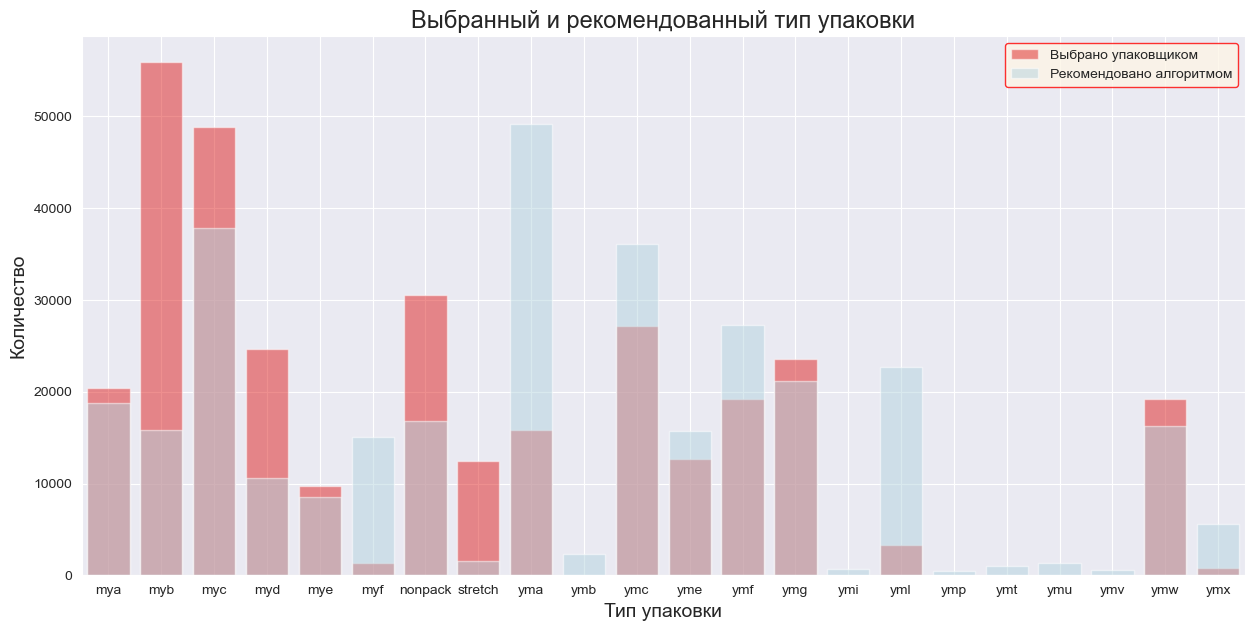

In [62]:
plt.figure(figsize=(15, 7))
plt.title('Выбранный и рекомендованный тип упаковки', fontsize=17)
sns.set_style('darkgrid')
sns.barplot(data=pivot_cargo_type,
            x=pivot_cargo_type.index,
            y='orderkey_sel',
            color='red',
            alpha=0.5,
            label = "Выбрано упаковщиком")
sns.barplot(data=pivot_cargo_type,
            x=pivot_cargo_type.index,
            y='orderkey_rec',
            color='lightblue',
            alpha=0.5,
            label = "Рекомендовано алгоритмом")
plt.ylabel('Количество', fontsize=14)
plt.xlabel('Тип упаковки', fontsize=14)
plt.grid(True)
plt.legend(edgecolor = 'r', facecolor = 'oldlace');

**Как видим в большинстве случаев рекомендации системы не совпадают с выбором пользователей.**

**Сравним цены и размеры упаковок, рекомендованных алгоритмоми выборанных упаковщиком.**

In [63]:
carton_dict = carton.set_index('cartontype').T.to_dict('list')
carton_price_dict = carton_price.set_index('cartontype').T.to_dict('list')

In [64]:
data['recomended_price_for_pack'] = data['recommended_cartontype'].apply(lambda x:(carton_price_dict[x])[0] if carton_price_dict.get(x, 0) != 0 else 0)
data['selected_price_for_pack'] = data['selected_cartontype'].apply(lambda x:(carton_dict[x])[0] if carton_dict.get(x, 0) != 0 else 0)

**Посмотрим на цены**

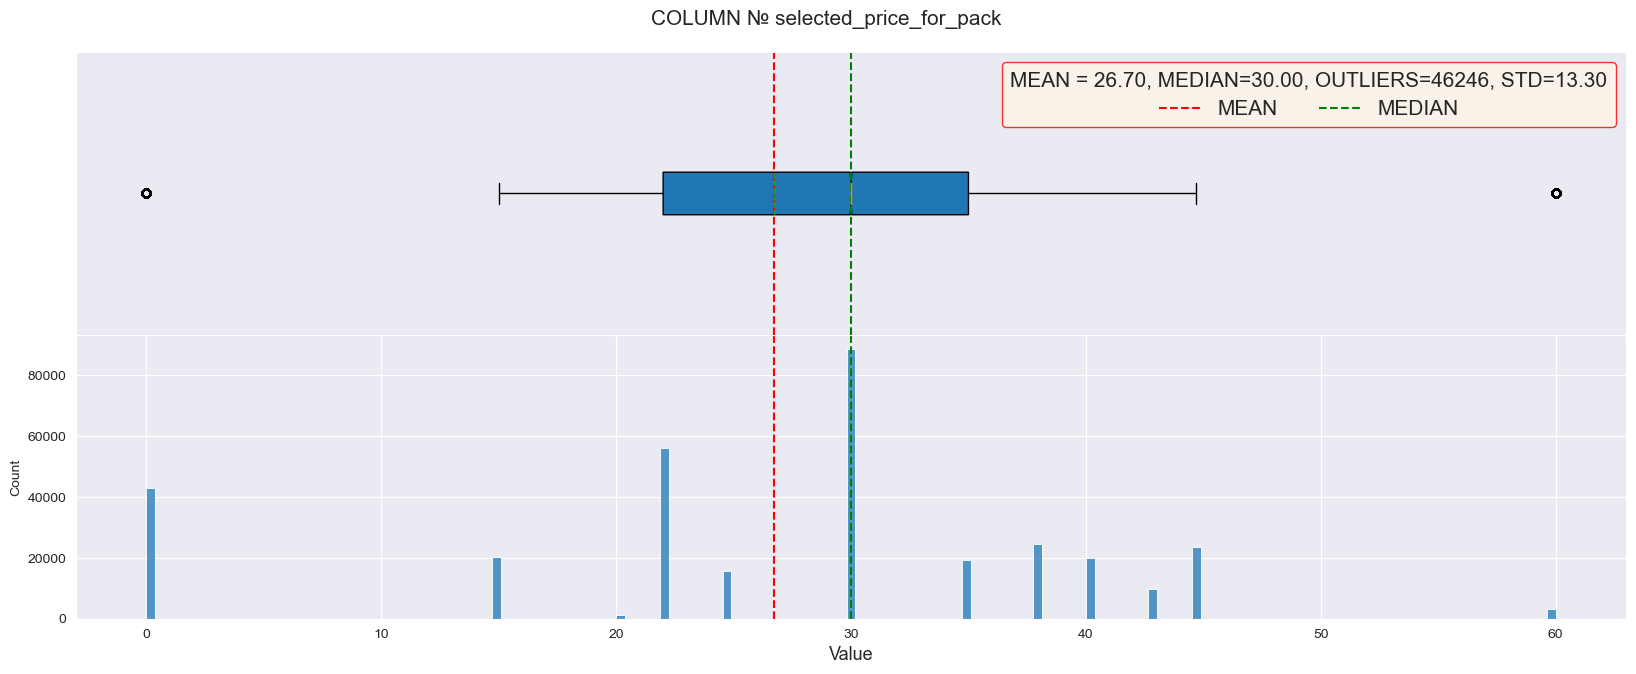

In [65]:
plot_charts(data, ['selected_price_for_pack'])

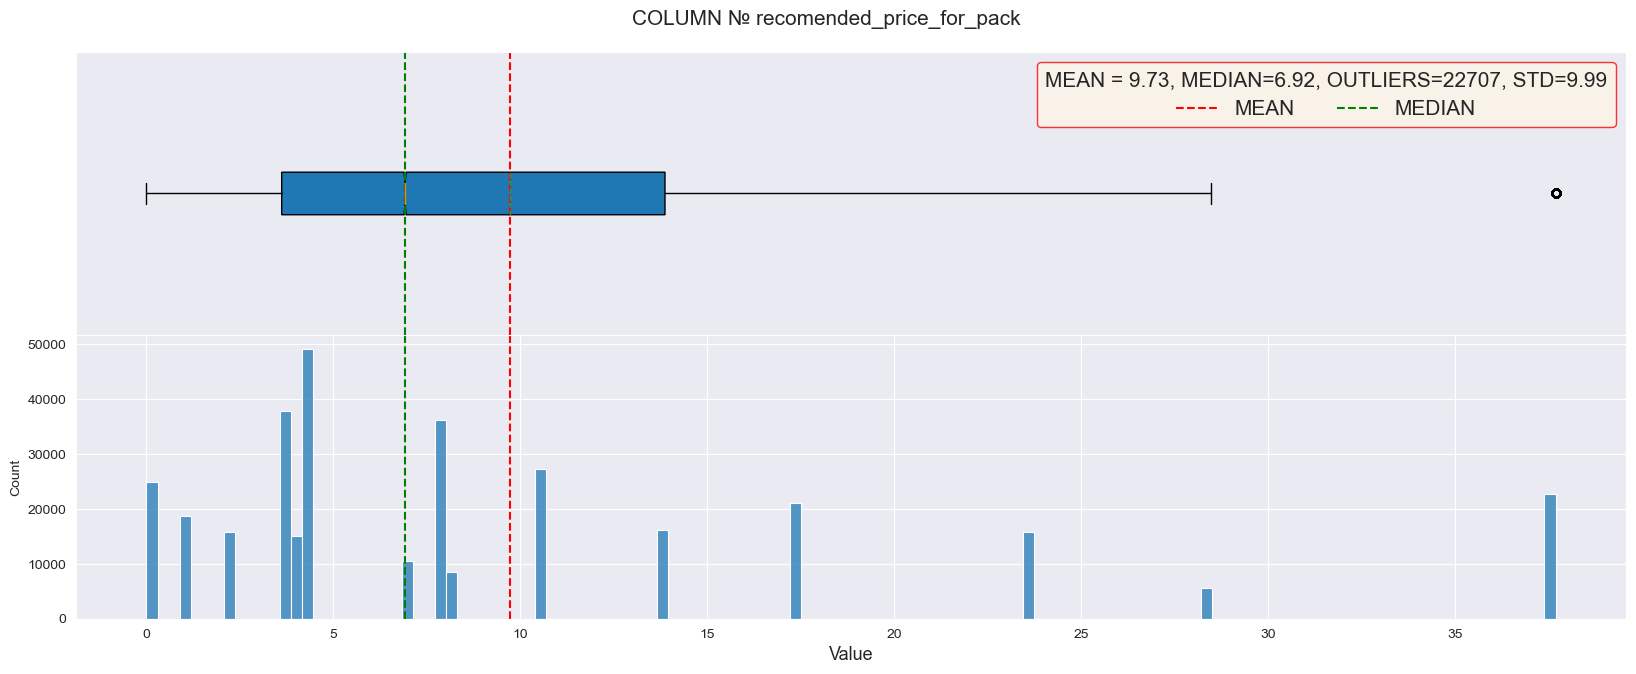

In [66]:
plot_charts(data, ['recomended_price_for_pack'])

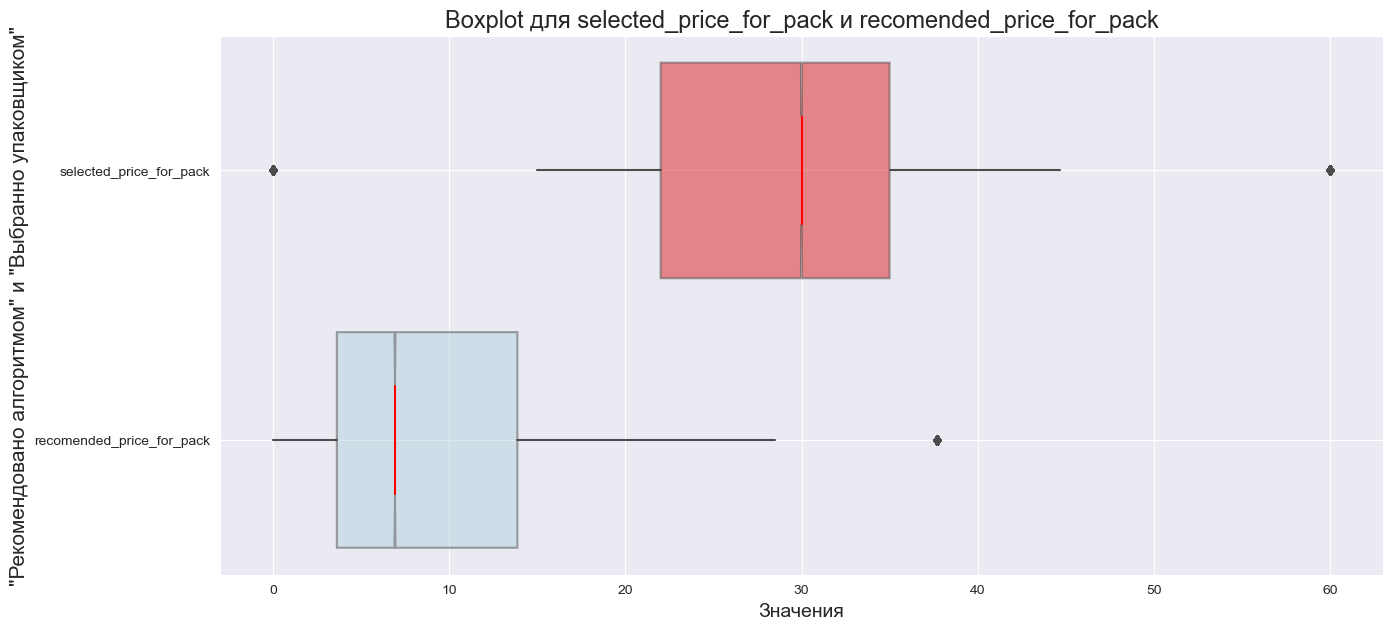

In [67]:
plot_two_boxplot('selected_price_for_pack', 'recomended_price_for_pack')

**Алгоритм старается экономить на упаковке в отличие от упаковщика. Возможно выбор работника связан с желанием обезапасить товары** 

**Так же в наборе присутствуют аномалии для цены упаковки, выбранной упаковщиком.**

**Теперь рассмотрим рекомендованные и выбранные размеры для упаковки**

In [68]:
data['recomended_length_for_pack'] = data['recommended_cartontype'].apply(lambda x:(carton_dict[x])[0] if carton_dict.get(x, 0) != 0 else 0)
data['selected_length_for_pack'] = data['selected_cartontype'].apply(lambda x:(carton_dict[x])[0] if carton_dict.get(x, 0) != 0 else 0)

data['recomended_width_for_pack'] = data['recommended_cartontype'].apply(lambda x:(carton_dict[x])[1] if carton_dict.get(x, 0) != 0 else 0)
data['selected_width_for_pack'] = data['selected_cartontype'].apply(lambda x:(carton_dict[x])[1] if carton_dict.get(x, 0) != 0 else 0)

data['recomended_height_for_pack'] = data['recommended_cartontype'].apply(lambda x:(carton_dict[x])[2] if carton_dict.get(x, 0) != 0 else 0)
data['selected_height_for_pack'] = data['selected_cartontype'].apply(lambda x:(carton_dict[x])[2] if carton_dict.get(x, 0) != 0 else 0)

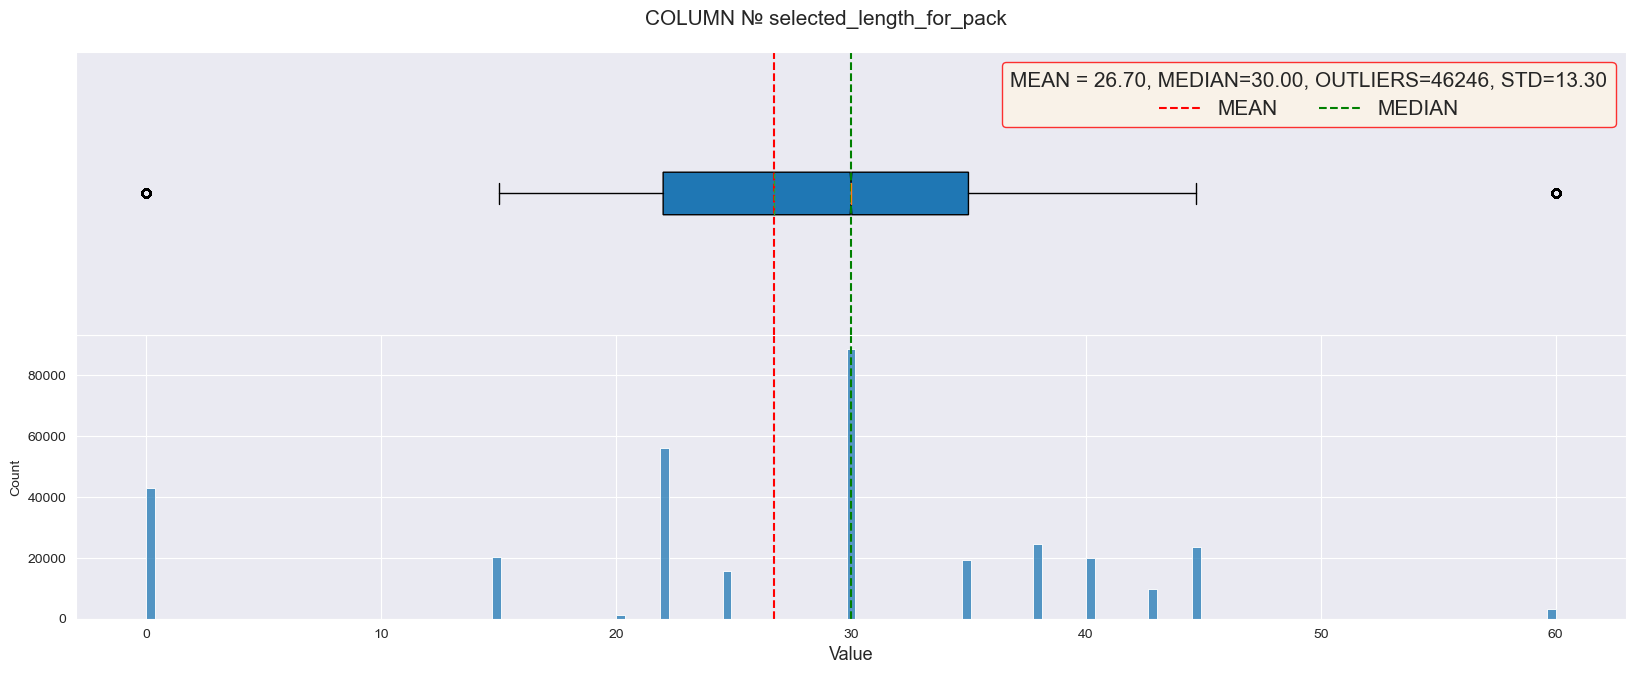

In [69]:
plot_charts(data, ['selected_length_for_pack'])

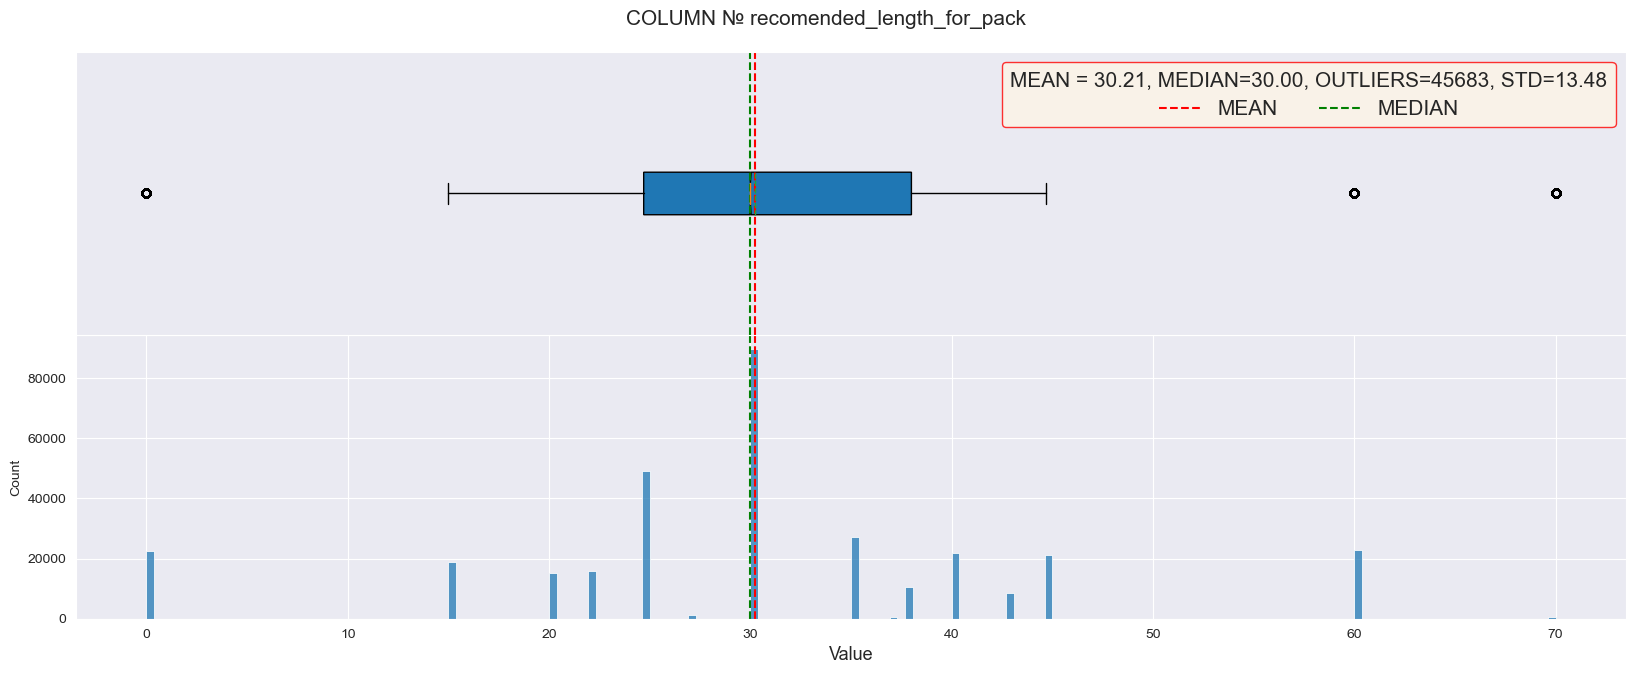

In [70]:
plot_charts(data, ['recomended_length_for_pack'])

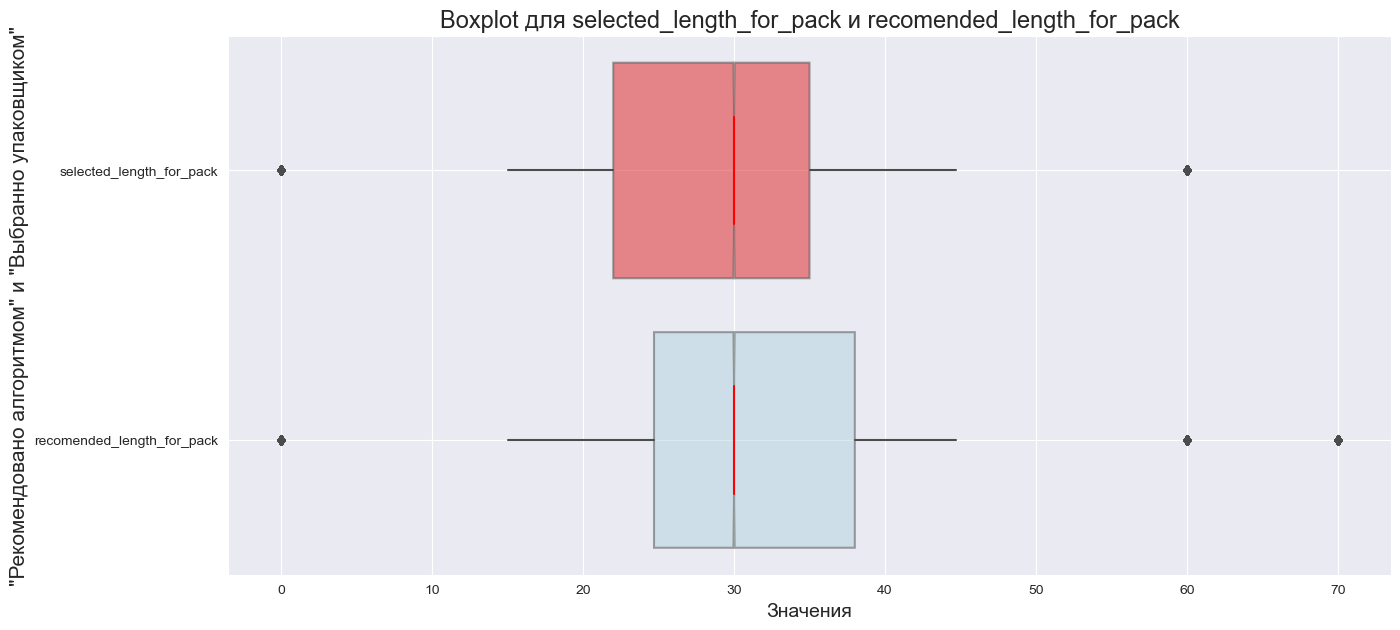

In [71]:
plot_two_boxplot('selected_length_for_pack', 'recomended_length_for_pack')

In [72]:
sel_len = data['selected_length_for_pack'].value_counts().reset_index().rename(columns={'index': 'sel_length', 'selected_length_for_pack': 'count'})
rec_len = data['recomended_length_for_pack'].value_counts().reset_index().rename(columns={'index': 'rec_length', 'recomended_length_for_pack': 'count'})

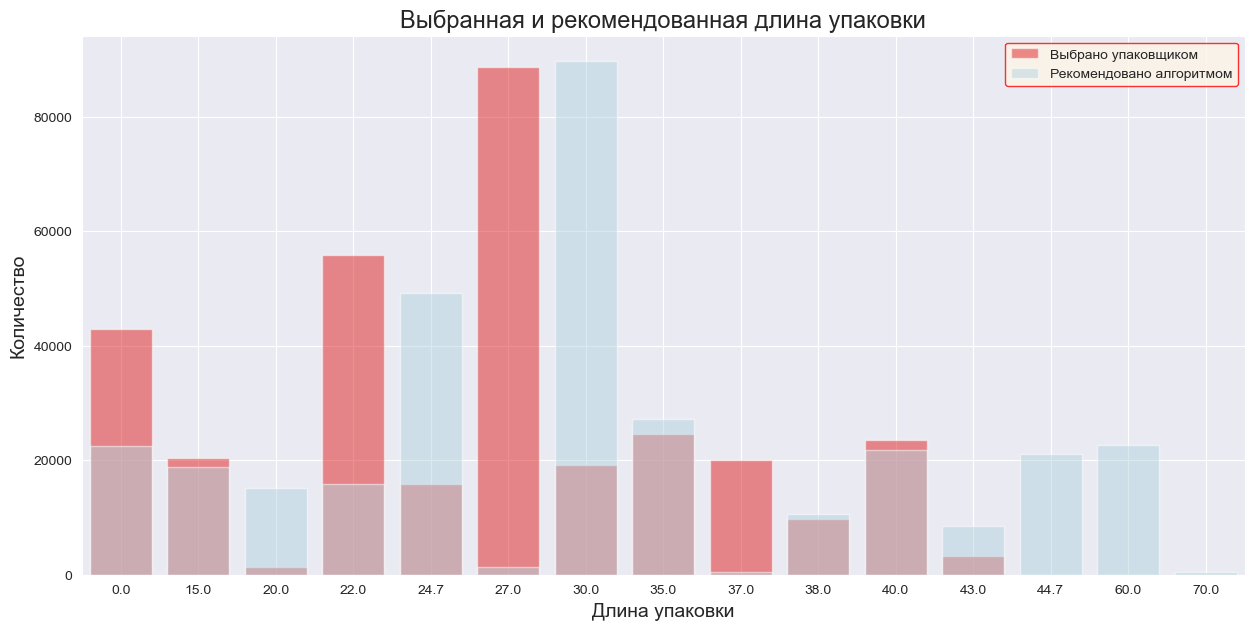

In [73]:
plt.figure(figsize=(15, 7))
plt.title('Выбранная и рекомендованная длина упаковки', fontsize=17)
sns.set_style('darkgrid')
sns.barplot(data=sel_len,
            x='sel_length',
            y='count',
            color='red',
            alpha=0.5,
            label = "Выбрано упаковщиком")
sns.barplot(data=rec_len,
            x='rec_length',
            y='count',
            color='lightblue',
            alpha=0.5,
            label = "Рекомендовано алгоритмом")
plt.ylabel('Количество', fontsize=14)
plt.xlabel('Длина упаковки', fontsize=14)
plt.grid(True)
plt.legend(edgecolor = 'r', facecolor = 'oldlace');

In [74]:
del sel_len, rec_len

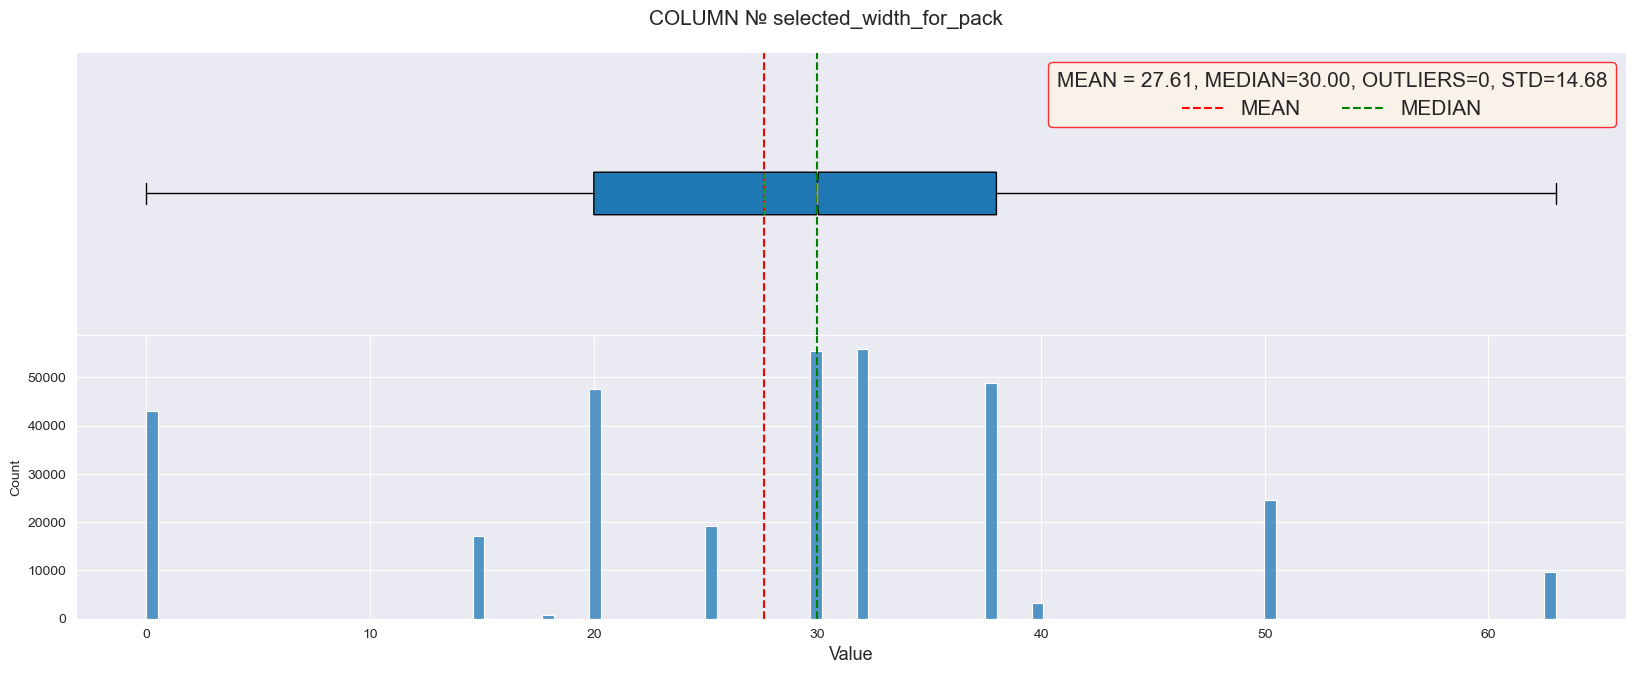

In [75]:
plot_charts(data, ['selected_width_for_pack'])

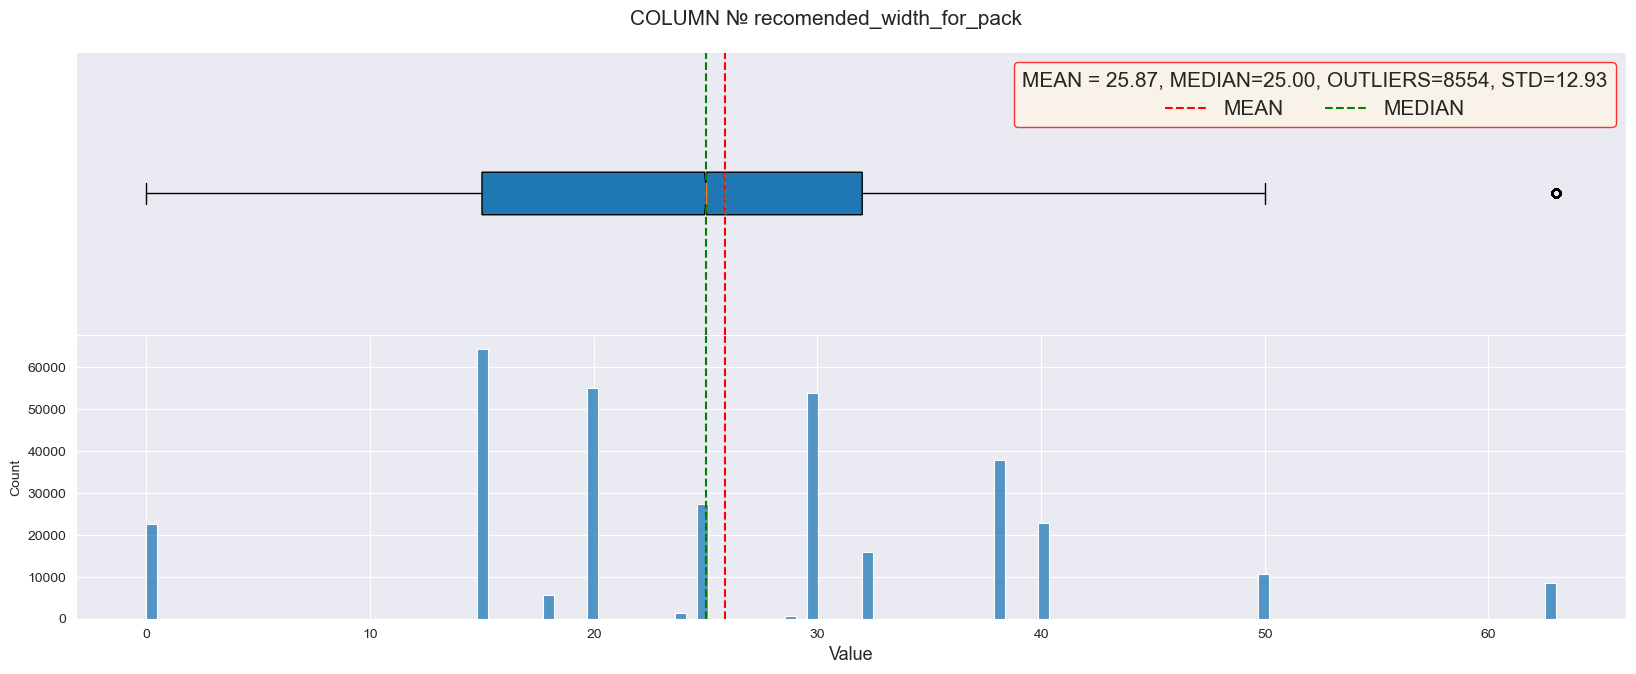

In [76]:
plot_charts(data, ['recomended_width_for_pack'])

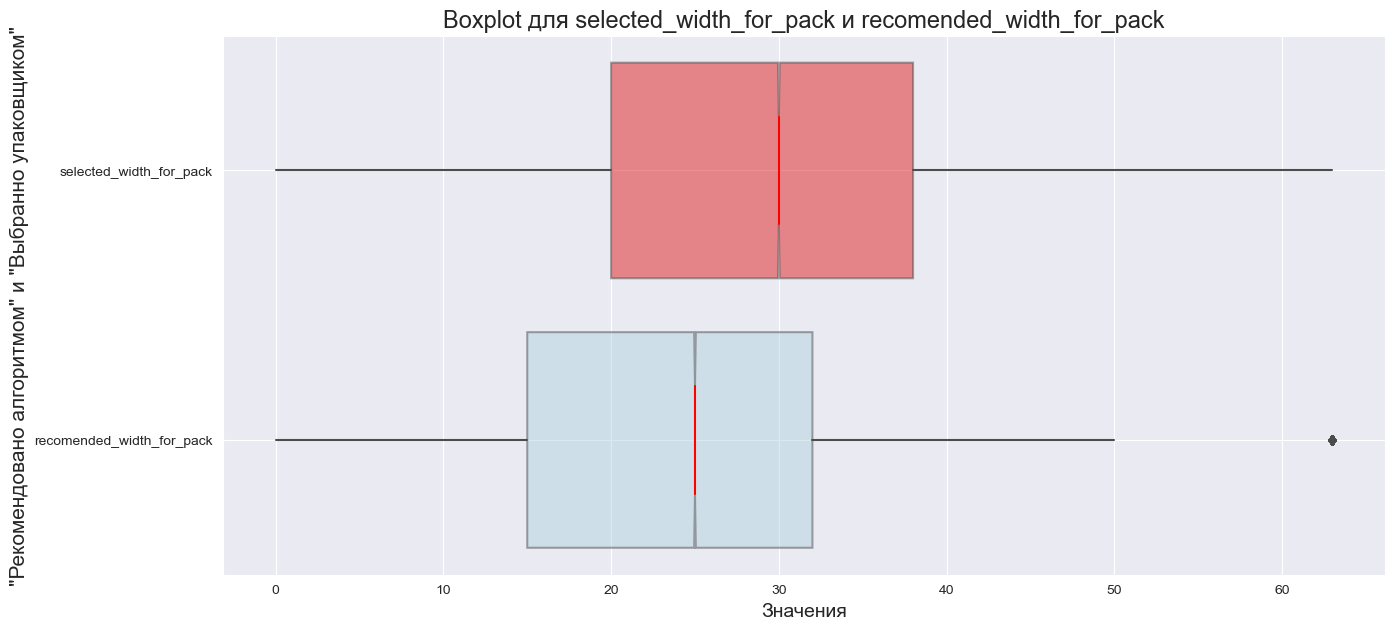

In [77]:
plot_two_boxplot('selected_width_for_pack', 'recomended_width_for_pack')

In [78]:
sel_width = data['selected_width_for_pack'].value_counts().reset_index().rename(columns={'index': 'sel_width', 'selected_width_for_pack': 'count'})
rec_width = data['recomended_width_for_pack'].value_counts().reset_index().rename(columns={'index': 'rec_width', 'recomended_width_for_pack': 'count'})

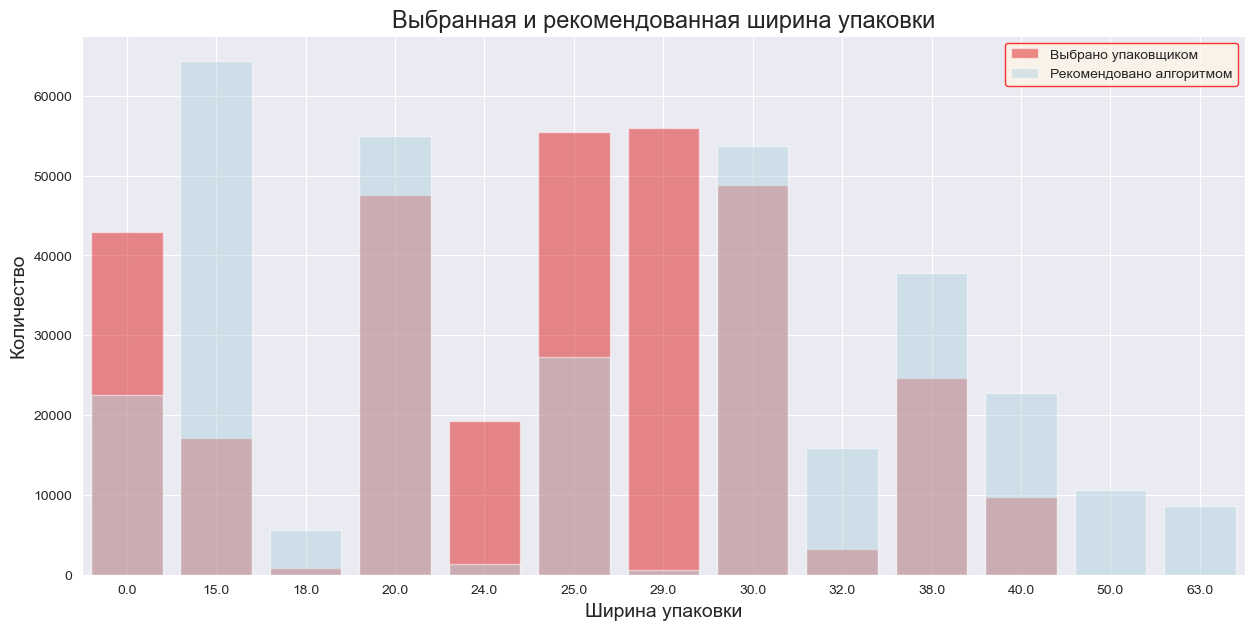

In [79]:
plt.figure(figsize=(15, 7))
plt.title('Выбранная и рекомендованная ширина упаковки', fontsize=17)
sns.set_style('darkgrid')
sns.barplot(data=sel_width,
            x='sel_width',
            y='count',
            color='red',
            alpha=0.5,
            label = "Выбрано упаковщиком")
sns.barplot(data=rec_width,
            x='rec_width',
            y='count',
            color='lightblue',
            alpha=0.5,
            label = "Рекомендовано алгоритмом")
plt.ylabel('Количество', fontsize=14)
plt.xlabel('Ширина упаковки', fontsize=14)
plt.grid(True)
plt.legend(edgecolor = 'r', facecolor = 'oldlace');

In [80]:
del sel_width, rec_width

In [81]:
sel_height = data['selected_height_for_pack'].value_counts().reset_index().rename(columns={'index': 'sel_height', 'selected_height_for_pack': 'count'})
rec_height = data['recomended_height_for_pack'].value_counts().reset_index().rename(columns={'index': 'rec_height', 'recomended_height_for_pack': 'count'})

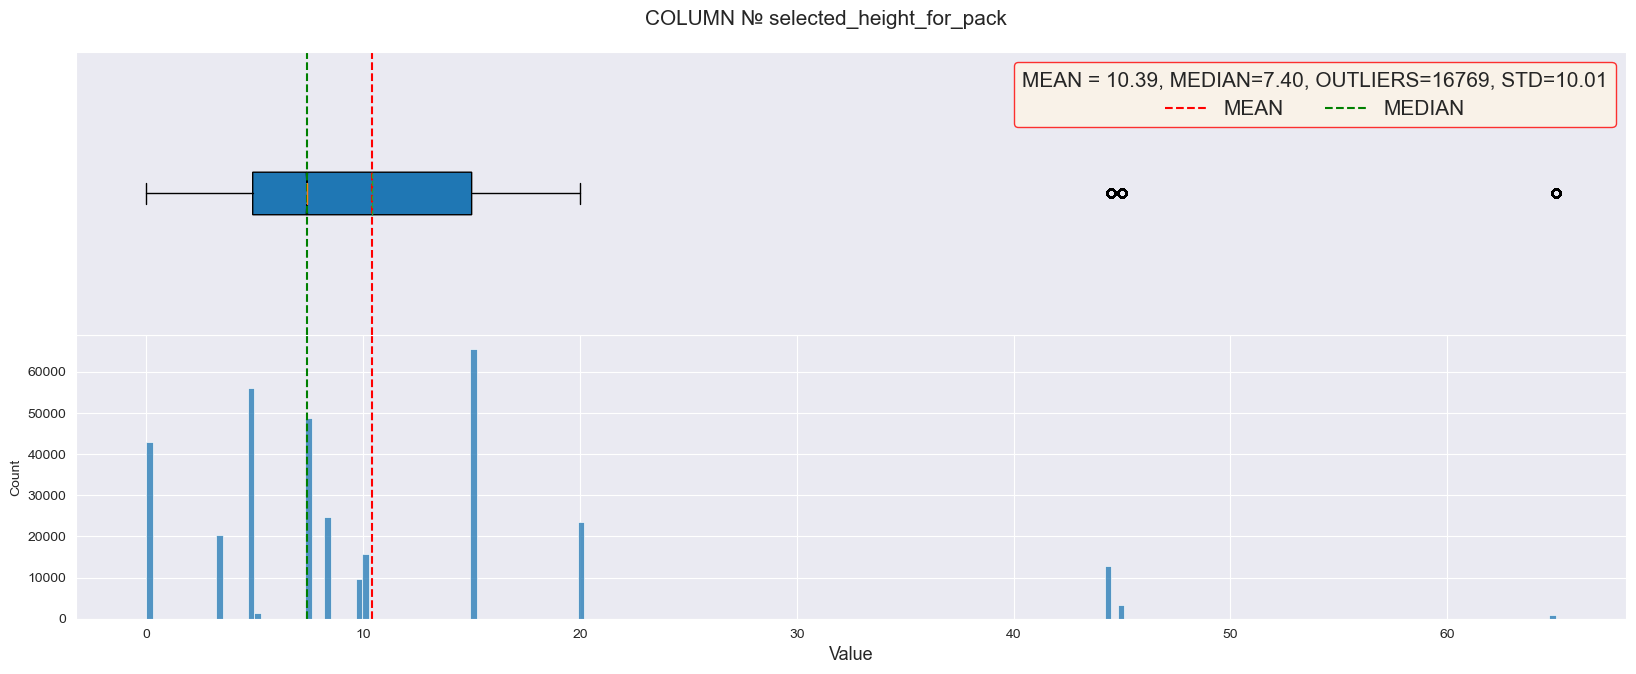

In [82]:
plot_charts(data, ['selected_height_for_pack'])

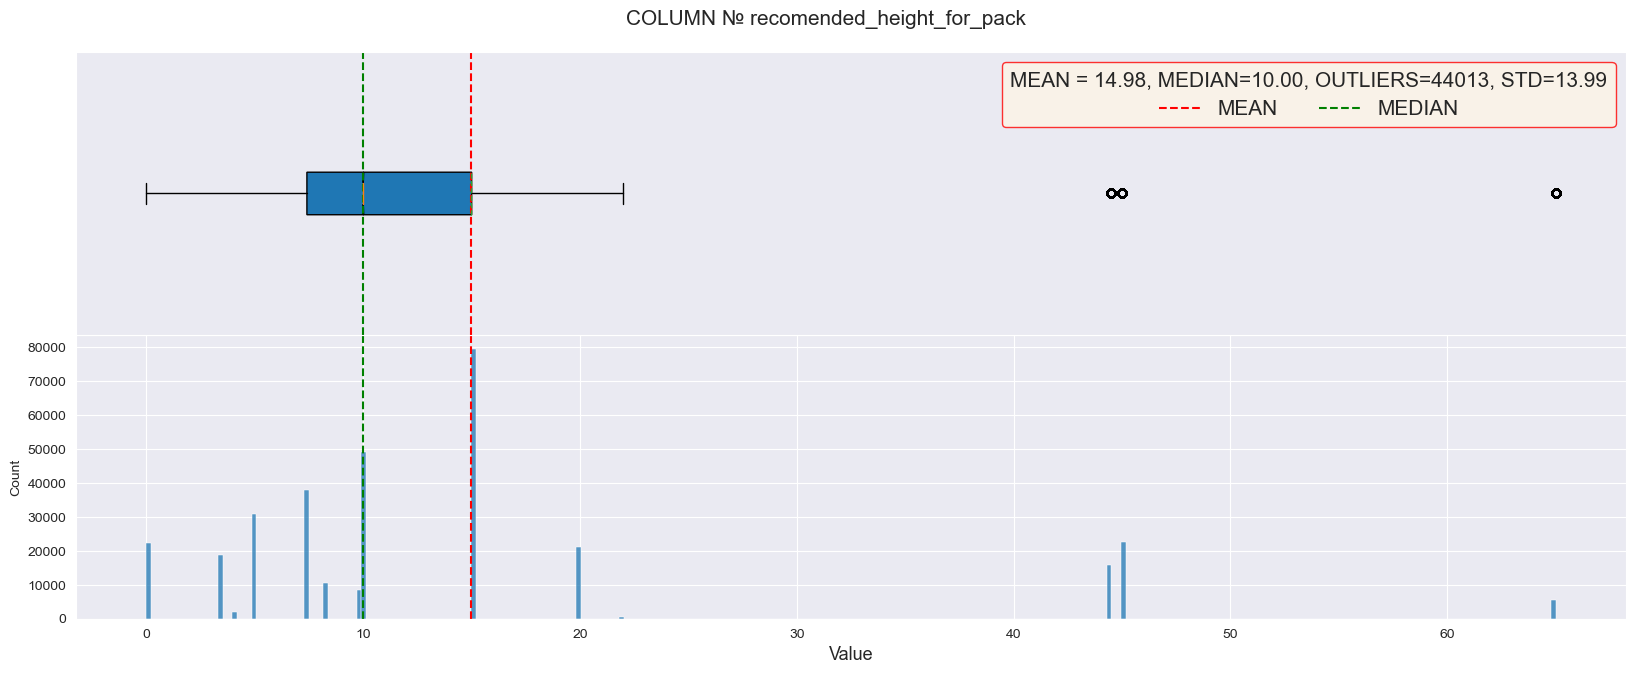

In [83]:
plot_charts(data, ['recomended_height_for_pack'])

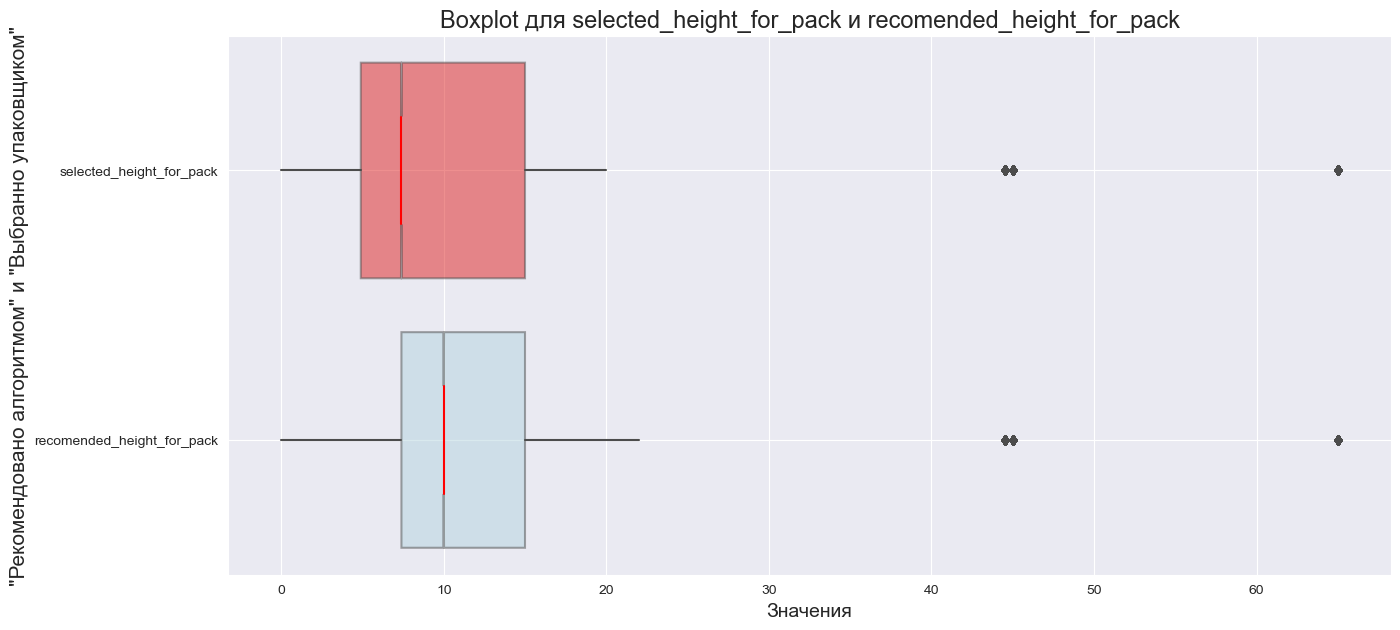

In [84]:
plot_two_boxplot('selected_height_for_pack', 'recomended_height_for_pack')

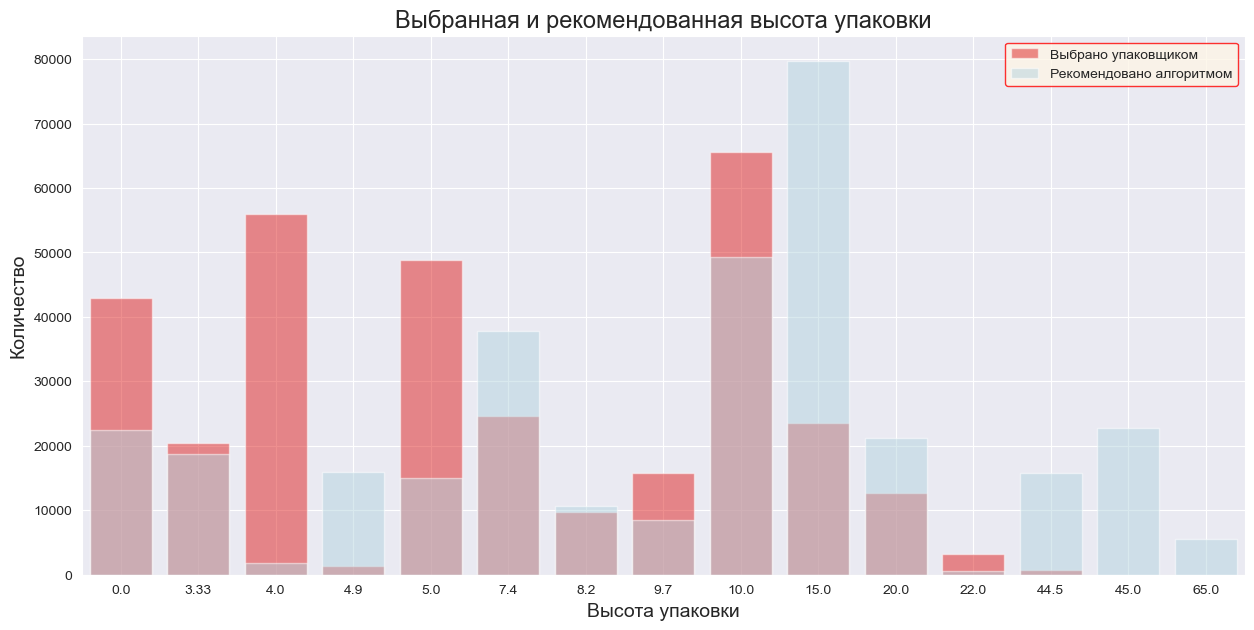

In [85]:
sel_height = data['selected_height_for_pack'].value_counts().reset_index().rename(columns={'index': 'sel_height', 'selected_height_for_pack': 'count'})
rec_height = data['recomended_height_for_pack'].value_counts().reset_index().rename(columns={'index': 'rec_height', 'recomended_height_for_pack': 'count'})

plt.figure(figsize=(15, 7))
plt.title('Выбранная и рекомендованная высота упаковки', fontsize=17)
sns.set_style('darkgrid')
sns.barplot(data=sel_height,
            x='sel_height',
            y='count',
            color='red',
            alpha=0.5,
            label = "Выбрано упаковщиком")
sns.barplot(data=rec_height,
            x='rec_height',
            y='count',
            color='lightblue',
            alpha=0.5,
            label = "Рекомендовано алгоритмом")
plt.ylabel('Количество', fontsize=14)
plt.xlabel('Высота упаковки', fontsize=14)
plt.grid(True)
plt.legend(edgecolor = 'r', facecolor = 'oldlace');

**Как видно из графиков алгоритм старается дать минимальные размеры упаковки для товара, в отличие от выбора человека. Разница в размерах может быть объяснена нацеленностью алгоритма на экономию денег на упаковке, а человека на сохранность товара. Большие по сравнению с выбором алгоритма габариты обьясняется тем, что в дополнительное пространство между товаром и стенками упаковки могут прокладывать бумагой или другим безопасным материалом.**

In [86]:
del carton, carton_dict, carton_price, carton_price_dict, pivot_cargo_type, sel_height, rec_height

## Объем, вес, коробки

In [87]:
cargotype_info['cargotype'] = cargotype_info['cargotype'].astype('int')

### Объем

**Построим гистограммы по всем числовым признакам**

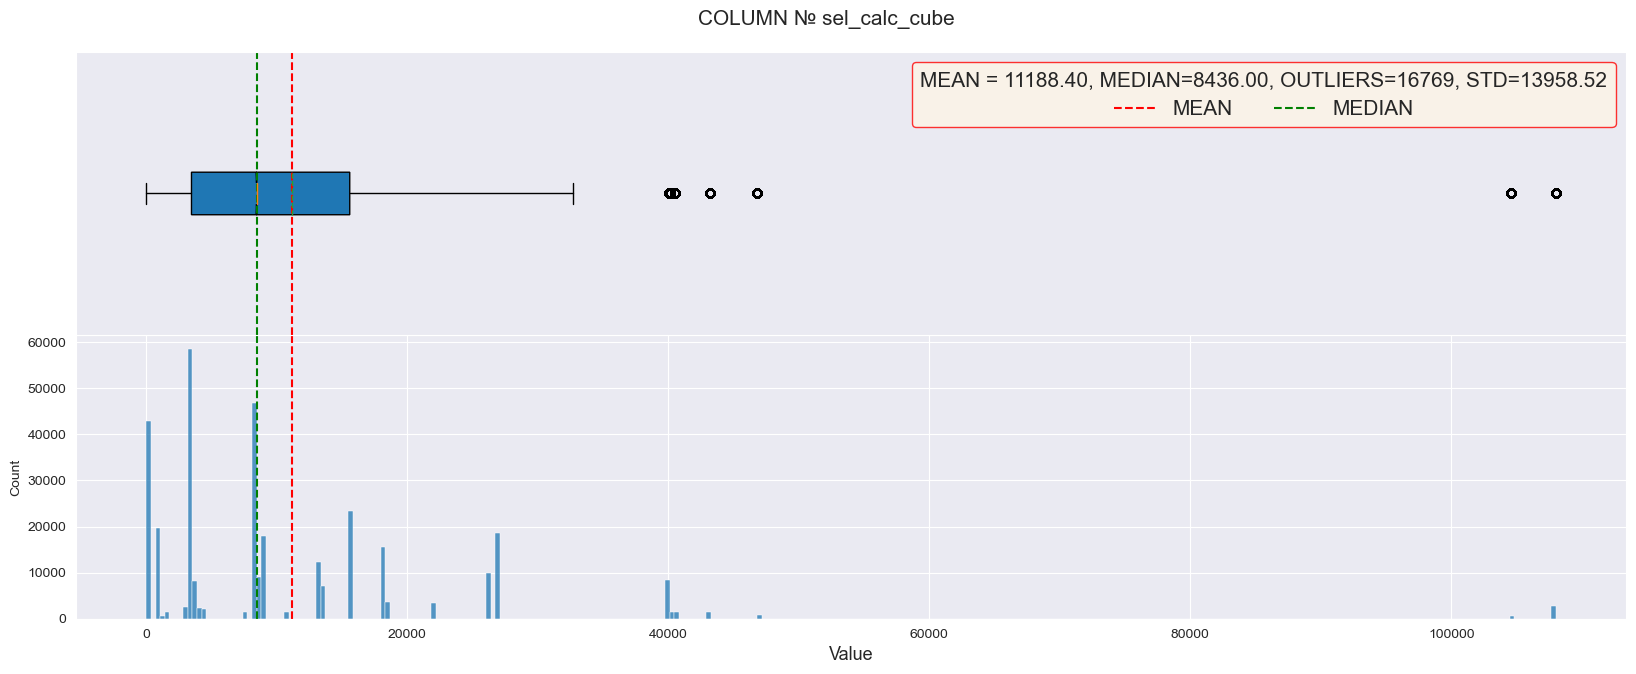

In [88]:
plot_charts(data, ['sel_calc_cube'])

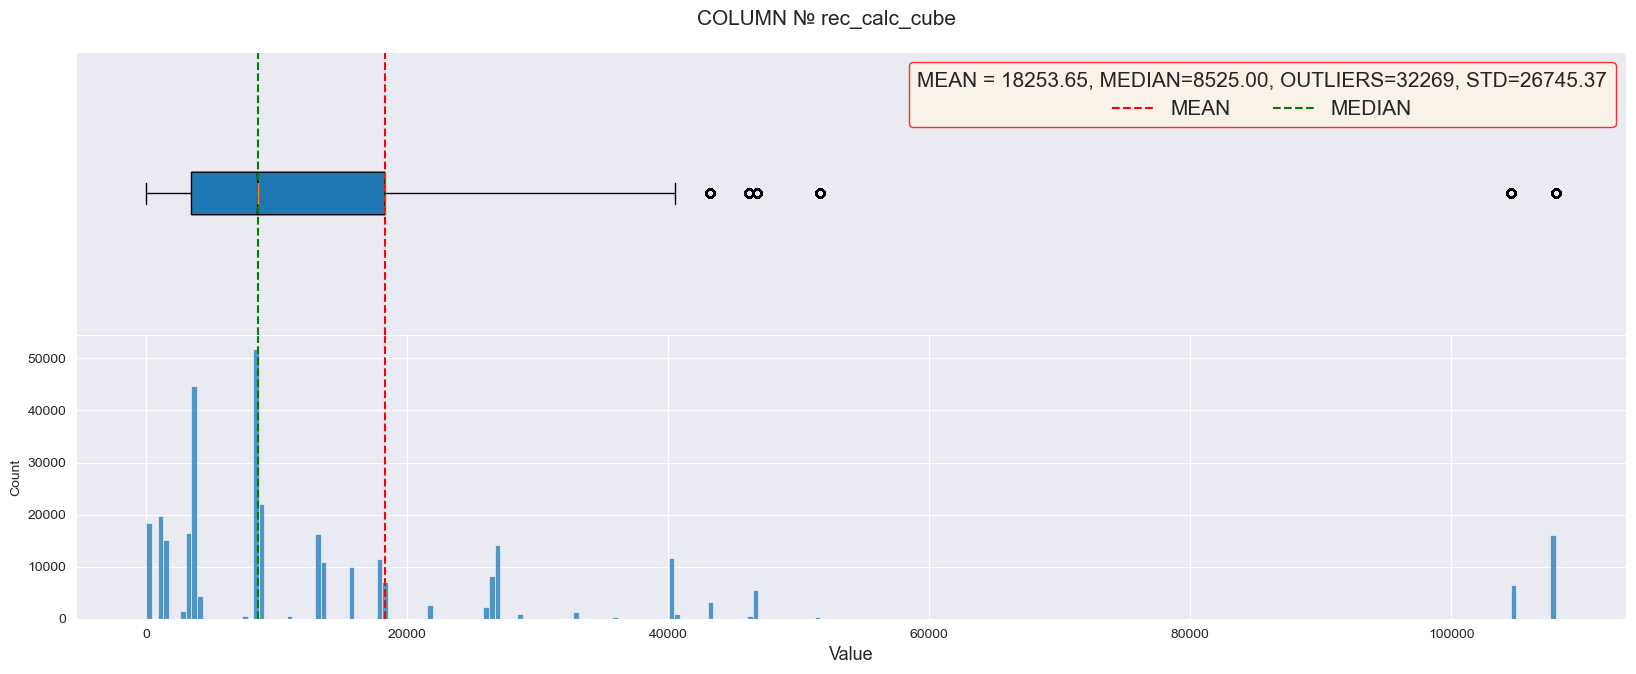

In [89]:
plot_charts(data, ['rec_calc_cube'])

**Сравним выбранный объём упаковки и рассчитанный объём.**

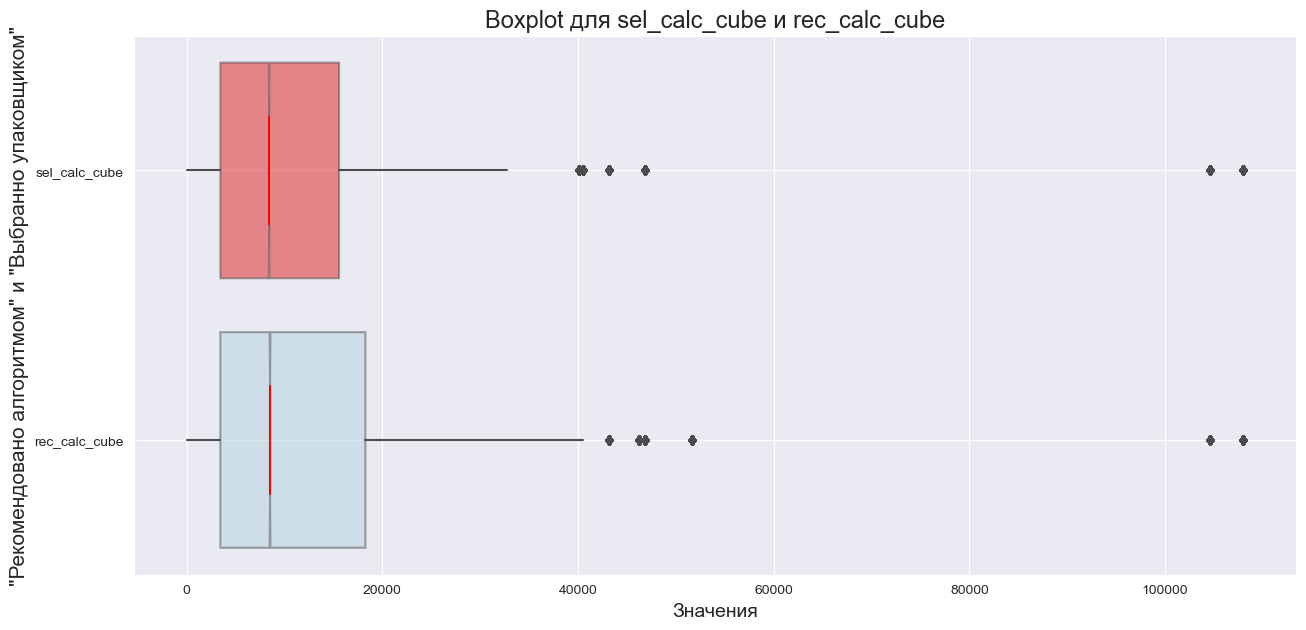

In [90]:
plot_two_boxplot('sel_calc_cube', 'rec_calc_cube')

**Учитывая, что рекомендуемый объём упаковки, иногда бывает очень большим (1815450) а в реальности была выбрана упаковка гораздо меньше, то отбросим такие пиковые значения.**

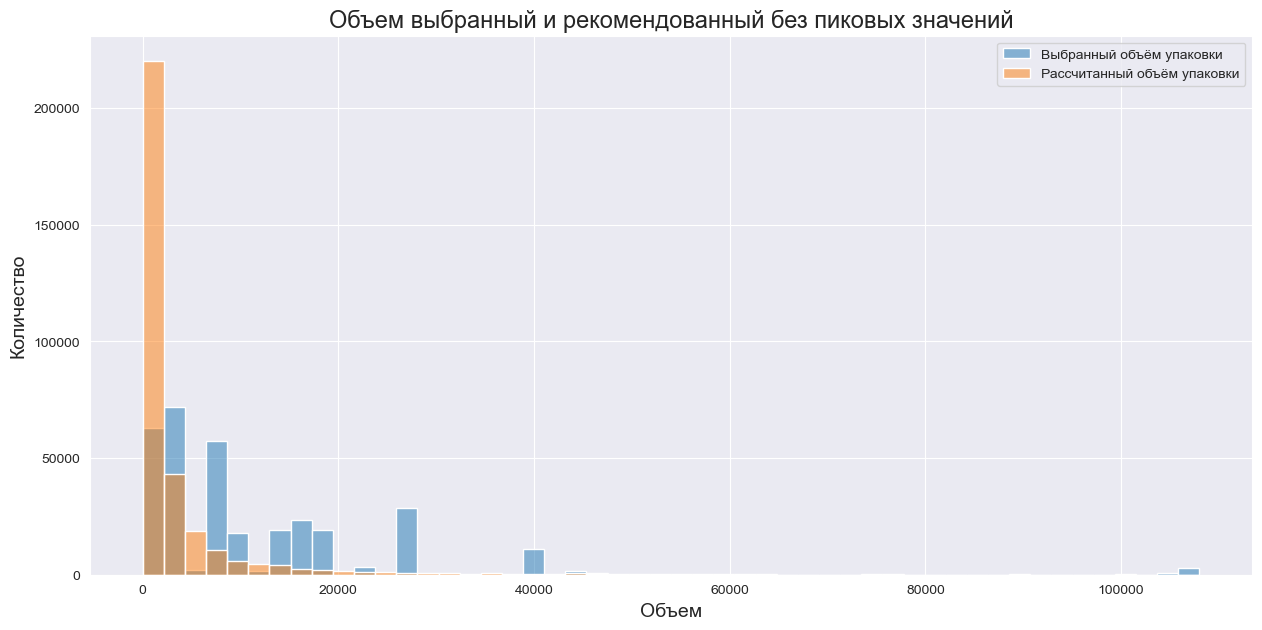

In [91]:
plt.figure(figsize=(15, 7))
plt.title('Объем выбранный и рекомендованный без пиковых значений', fontsize=17)
sns.histplot(data[data['pack_volume']<=108000]['sel_calc_cube'], bins=50, label='Выбранный объём упаковки', alpha=0.5)
sns.histplot(data[data['pack_volume']<=108000]['pack_volume'], bins=50, label='Рассчитанный объём упаковки', alpha=0.5)
plt.ylabel('Количество', fontsize=14)
plt.xlabel('Объем', fontsize=14)
plt.legend()
plt.show()

**Видно, что текущая система стремиться дать минимальный объём.**

**Из графика 'Медианное значение по упоковкам для минимального и максимального габарита' мы узнали, что большие изделия чаще имеют упаковку NONPACK и STRETCH так что эти признаки могут помочь модели обучиться.
Посмотрим влияет ли на выбор упаковки объём товара для этого добавим столбец volume_sku**

In [92]:
data['volume_sku'] = data['a'] * data['b'] * data['c']
data['volume_sku'] = data[~data['a'].isna()]['volume_sku'].fillna(0)

In [93]:
pivot_df_volume_sku = data.pivot_table(index='selected_cartontype', values='volume_sku', aggfunc='median')

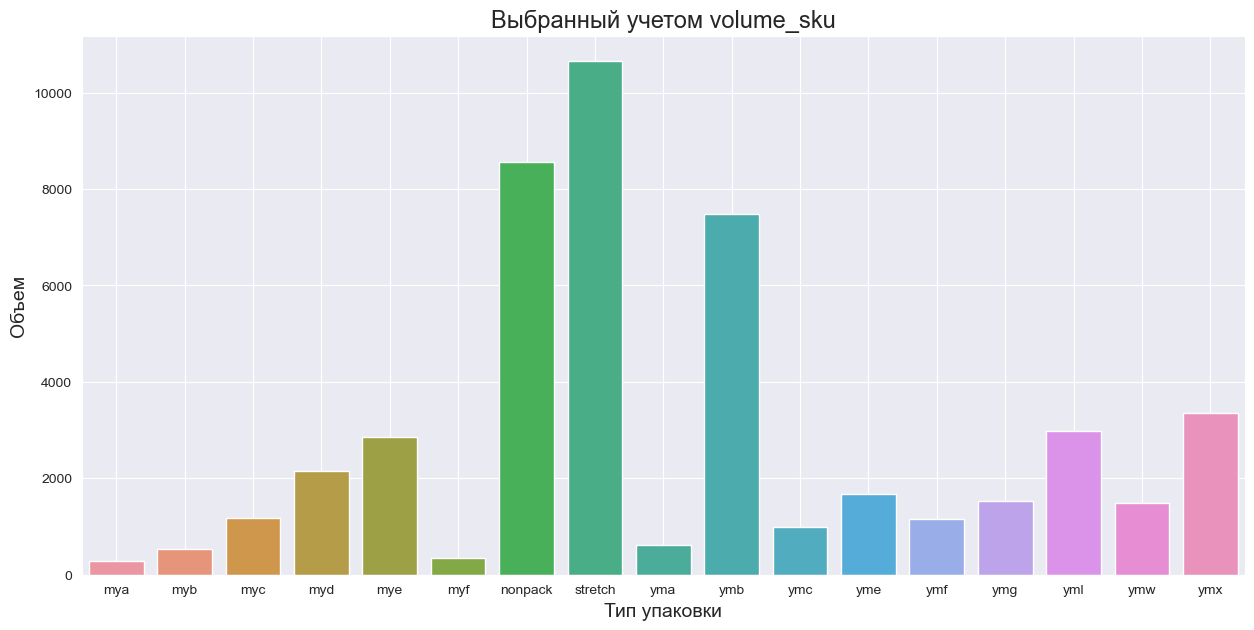

In [94]:
plt.figure(figsize=(15, 7))
plt.title('Выбранный учетом volume_sku', fontsize=17)
sns.set_style('darkgrid')
sns.barplot(data=pivot_df_volume_sku,
            x=pivot_df_volume_sku.index,
            y='volume_sku')
plt.ylabel('Объем', fontsize=14)
plt.xlabel('Тип упаковки', fontsize=14)
plt.grid(True);

**Объём тоже влияет на выбор упаковки, можно явно выделить какие упаковки предпочитают для товаров с большим и малым объёмом.**

**Проведём аналогичные исследования по весу товара**

In [95]:
pivot_df_wght = data.pivot_table(index='selected_cartontype', values='goods_wght', aggfunc='median') 

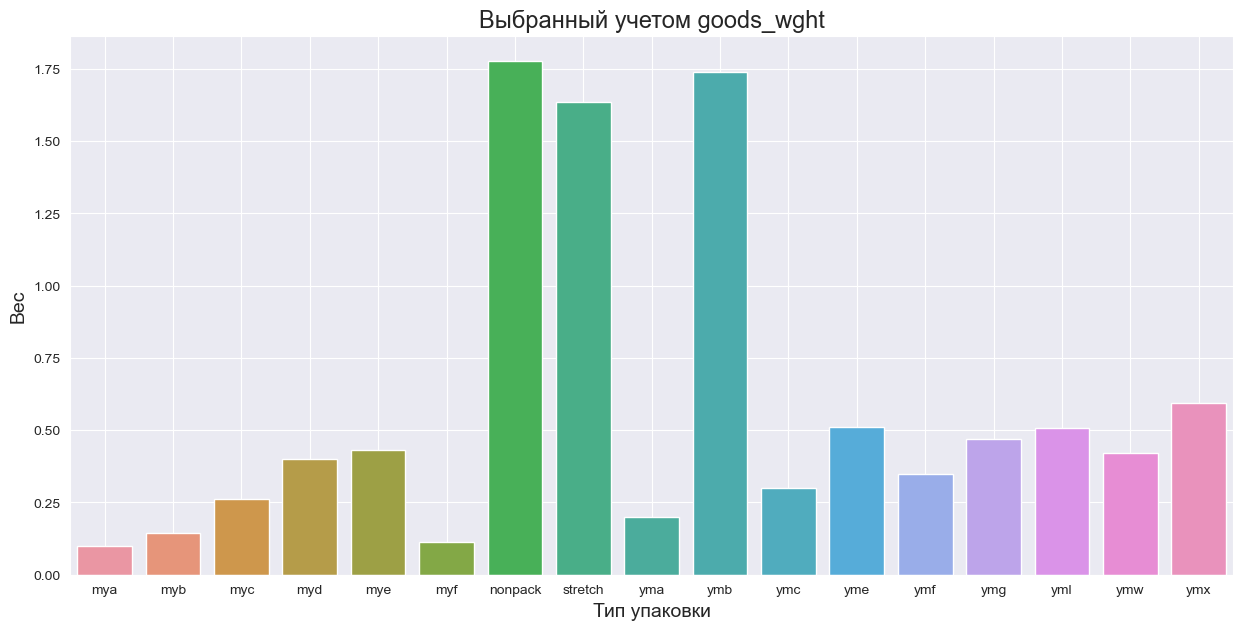

In [96]:
plt.figure(figsize=(15, 7))
plt.title('Выбранный учетом goods_wght', fontsize=17)
sns.set_style('darkgrid')
sns.barplot(data=pivot_df_wght,
            x=pivot_df_wght.index,
            y='goods_wght')
plt.ylabel('Вес', fontsize=14)
plt.xlabel('Тип упаковки', fontsize=14)
plt.grid(True);

**Теже самые три упаковки, которые относятся к крупно габаритным товарам также предпочитают и для тяжёлых товаров**

**Рассмотрим влияние удельного объёмного веса на выбор упаковки**

In [97]:
data['specific_weight'] = data['goods_wght'] / data['volume_sku']

In [98]:
pivot_df_sw = data.pivot_table(index='selected_cartontype', values='specific_weight', aggfunc='median') 

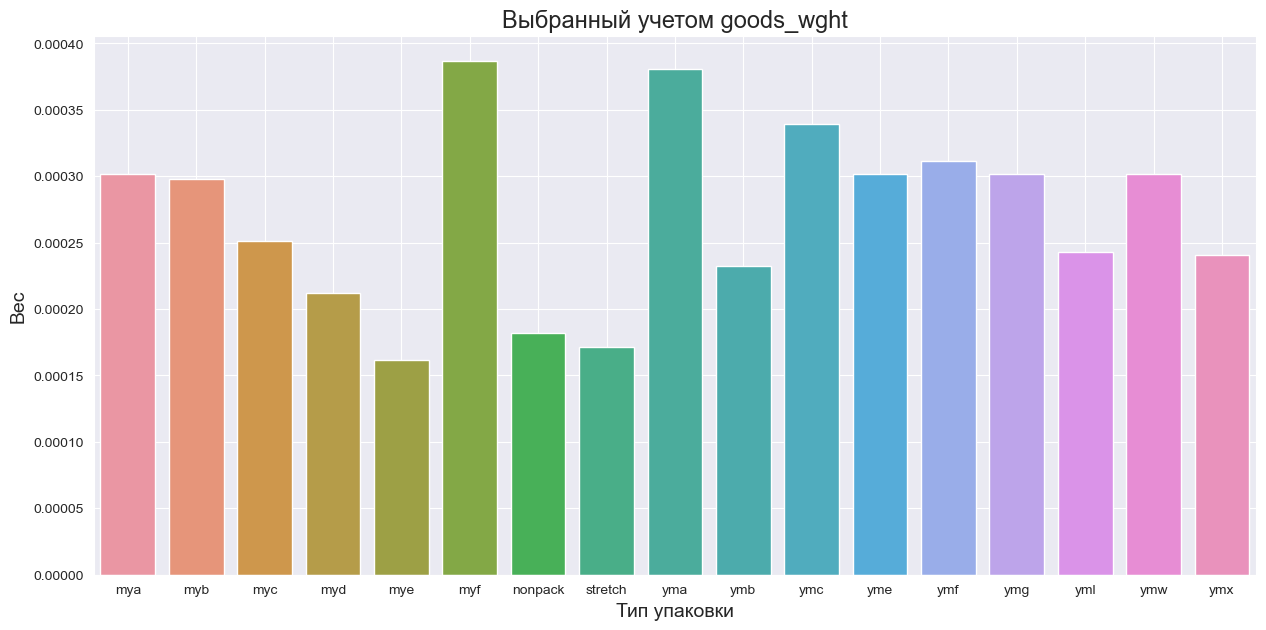

In [99]:
plt.figure(figsize=(15, 7))
plt.title('Выбранный учетом goods_wght', fontsize=17)
sns.set_style('darkgrid')
sns.barplot(data=pivot_df_sw,
            x=pivot_df_sw.index,
            y='specific_weight')
plt.ylabel('Вес', fontsize=14)
plt.xlabel('Тип упаковки', fontsize=14)
plt.grid(True);

**Сложно сделать однозначный вывод по таким данным, нужно будет смотреть на обучение модели, возможно ей пригодиться такой признак.**

In [100]:
del pivot_df_volume_sku, pivot_df_wght, pivot_df_sw

### Коробки

**Проанализируем сколько товаров попадает в один заказ и сколько коробок для этого предлагают**

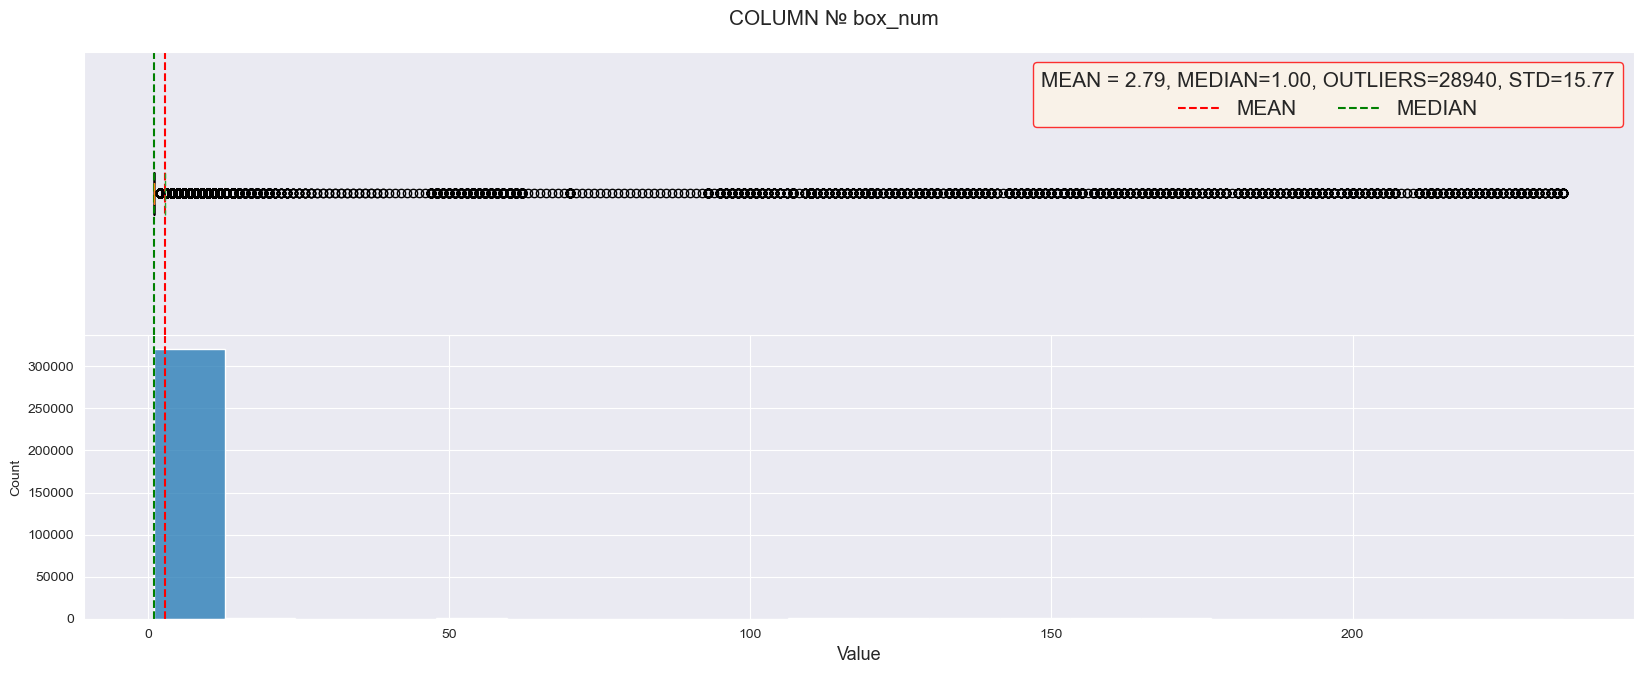

In [101]:
plot_charts(data, ['box_num'])

In [102]:
data_pivot = data.pivot_table(index='orderkey', values='box_num',aggfunc=['count', 'sum'])
data_pivot.head()

,count,sum
,box_num,box_num
orderkey,,
00004fc4755eeb7e851e52ec91130fe4,1,1
00008e765c2d85abfa9c97563afd98ef,1,1
0000c268eb1be1dd5b8c1a032f7318fc,3,3
0000fc4c7acac6e89f82392b90e47a27,2,2
0001963724fa4cc12d4f025056085633,10,10


In [103]:
data[data['orderkey'] == '0000fc4c7acac6e89f82392b90e47a27']

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid,a,b,c,list_demensions,recomended_price_for_pack,selected_price_for_pack,recomended_length_for_pack,selected_length_for_pack,recomended_width_for_pack,selected_width_for_pack,recomended_height_for_pack,selected_height_for_pack,volume_sku,specific_weight
185775,0,0000fc4c7acac6e89f82392b90e47a27,myb,1,yma,myb,3449,yma,792,3705,0.2,93c76085979851f91f4e276555c84efc,d99a39edbaa799fc0d1c68faa64e4a29,23f33fe4124497974701122ea988cc57,6.0,6.0,22.0,"[6.0, 6.0, 22.0]",4.392937,22.0,24.7,22.0,15.0,32.0,10.0,4.9,792.0,0.000253
185780,0,0000fc4c7acac6e89f82392b90e47a27,myb,1,yma,myb,3449,yma,624,3705,0.2,4ac273ebe2c3a48830ebddbdac5e74fe,d99a39edbaa799fc0d1c68faa64e4a29,23f33fe4124497974701122ea988cc57,6.0,8.0,13.0,"[6.0, 8.0, 13.0]",4.392937,22.0,24.7,22.0,15.0,32.0,10.0,4.9,624.0,0.000321


In [104]:
data[data['orderkey'] == '49a255ef0fa15f30c54251d9e386e480']

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid,a,b,c,list_demensions,recomended_price_for_pack,selected_price_for_pack,recomended_length_for_pack,selected_length_for_pack,recomended_width_for_pack,selected_width_for_pack,recomended_height_for_pack,selected_height_for_pack,volume_sku,specific_weight
325328,7,49a255ef0fa15f30c54251d9e386e480,nonpack,3,nonpack,nonpack,0,nonpack,1617,0,0.43,29dbb42befa2f176eb50828deba50afc,ce21d9ab9bf6770610560ee7f6ec6602,39ac79bc96a1e2d66f1aa61885e5c9ae,3.0,6.0,77.0,"[3.0, 6.0, 77.0]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1386.0,0.00031
325422,7,49a255ef0fa15f30c54251d9e386e480,nonpack,5,nonpack,nonpack,0,nonpack,1617,0,0.43,29dbb42befa2f176eb50828deba50afc,ce21d9ab9bf6770610560ee7f6ec6602,87ad8aaf104d6382a14e2af6399ec67b,3.0,6.0,77.0,"[3.0, 6.0, 77.0]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1386.0,0.00031
325423,7,49a255ef0fa15f30c54251d9e386e480,nonpack,1,nonpack,nonpack,0,nonpack,1617,0,0.43,29dbb42befa2f176eb50828deba50afc,ce21d9ab9bf6770610560ee7f6ec6602,bfb101d82cf7b65fa6a22331c288a2a4,3.0,6.0,77.0,"[3.0, 6.0, 77.0]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1386.0,0.00031
325435,7,49a255ef0fa15f30c54251d9e386e480,nonpack,2,nonpack,nonpack,0,nonpack,1617,0,0.43,29dbb42befa2f176eb50828deba50afc,ce21d9ab9bf6770610560ee7f6ec6602,ede3c79e6baebbbf1d581d0bbd4dc084,3.0,6.0,77.0,"[3.0, 6.0, 77.0]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1386.0,0.00031
325608,7,49a255ef0fa15f30c54251d9e386e480,nonpack,4,nonpack,nonpack,0,nonpack,1617,0,0.43,29dbb42befa2f176eb50828deba50afc,ce21d9ab9bf6770610560ee7f6ec6602,2152f99eb6f0a15bd602e409c83591f9,3.0,6.0,77.0,"[3.0, 6.0, 77.0]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1386.0,0.00031


In [105]:
data[data['orderkey'] == '46c39f23ec7f3e6ba6776d01c7edb4b9']

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid,a,b,c,list_demensions,recomended_price_for_pack,selected_price_for_pack,recomended_length_for_pack,selected_length_for_pack,recomended_width_for_pack,selected_width_for_pack,recomended_height_for_pack,selected_height_for_pack,volume_sku,specific_weight
62,0,46c39f23ec7f3e6ba6776d01c7edb4b9,nonpack,8,stretch,nonpack,0,stretch,1512,0,0.4,b1db25e57c75bd09f52954a02450c3e7,0d5a07f7ac939ca7a4cc4afe355c7234,cfc14af6d5b5680d6216273d8a88f2a9,3.0,8.0,63.0,"[3.0, 8.0, 63.0]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1512.0,0.000265
63,0,46c39f23ec7f3e6ba6776d01c7edb4b9,nonpack,5,stretch,nonpack,0,stretch,1512,0,0.4,b1db25e57c75bd09f52954a02450c3e7,0d5a07f7ac939ca7a4cc4afe355c7234,b734afbe20aff760f39bc751d874aa78,3.0,8.0,63.0,"[3.0, 8.0, 63.0]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1512.0,0.000265
64,0,46c39f23ec7f3e6ba6776d01c7edb4b9,nonpack,6,stretch,nonpack,0,stretch,1512,0,0.4,b1db25e57c75bd09f52954a02450c3e7,0d5a07f7ac939ca7a4cc4afe355c7234,a8440f45d85a4366cabfca992977790e,3.0,8.0,63.0,"[3.0, 8.0, 63.0]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1512.0,0.000265
65,0,46c39f23ec7f3e6ba6776d01c7edb4b9,nonpack,7,stretch,nonpack,0,stretch,1512,0,0.4,b1db25e57c75bd09f52954a02450c3e7,0d5a07f7ac939ca7a4cc4afe355c7234,c6957ed24e7a191b9f16b98c84660dd5,3.0,8.0,63.0,"[3.0, 8.0, 63.0]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1512.0,0.000265
66,0,46c39f23ec7f3e6ba6776d01c7edb4b9,nonpack,9,stretch,nonpack,0,stretch,1512,0,0.4,b1db25e57c75bd09f52954a02450c3e7,0d5a07f7ac939ca7a4cc4afe355c7234,b7a7b0182aa5c543239c57d099b8510f,3.0,8.0,63.0,"[3.0, 8.0, 63.0]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1512.0,0.000265


In [106]:
print('Количество строк, кторые имеют больше 1 коробки -', data[data['box_num']>1]['box_num'].count())
print('\nКоличсетво заказов, которые повторяются больше 1 раза -', data_pivot[data_pivot[('count', 'box_num')]>1][('count', 'box_num')].count())

Количество строк, кторые имеют больше 1 коробки - 28940

Количсетво заказов, которые повторяются больше 1 раза - 55929


**Как видим реальных заказов почти в два раза больше чем строк с количеством коробок > 1. Либо тут дубли, либо это не количество коробок, либо кто-то некорректно заполнял данные.**

In [107]:
del data_pivot

### Вес

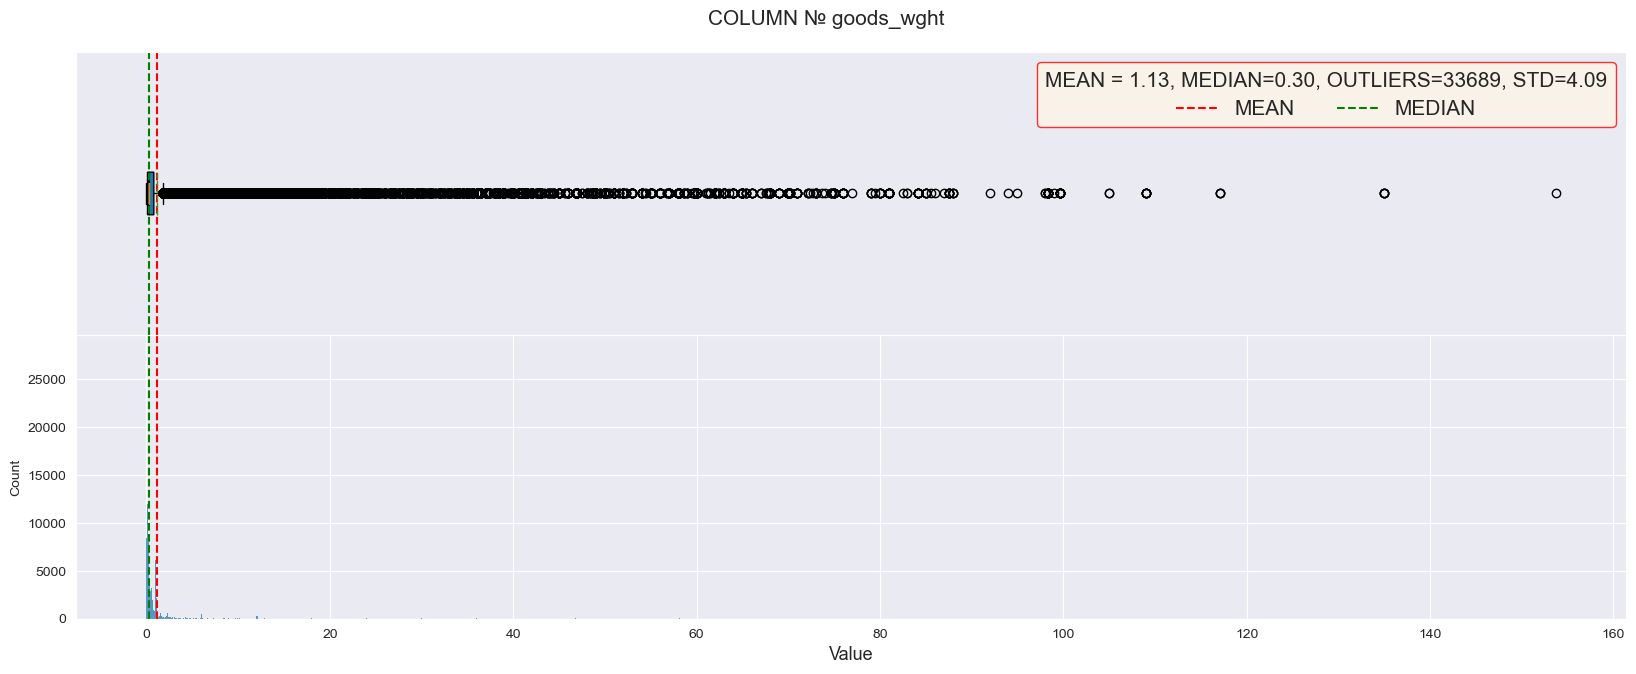

In [108]:
plot_charts(data, ['goods_wght'])

**В наборе есть аномалии с нулевым и большим(>60) весом.**

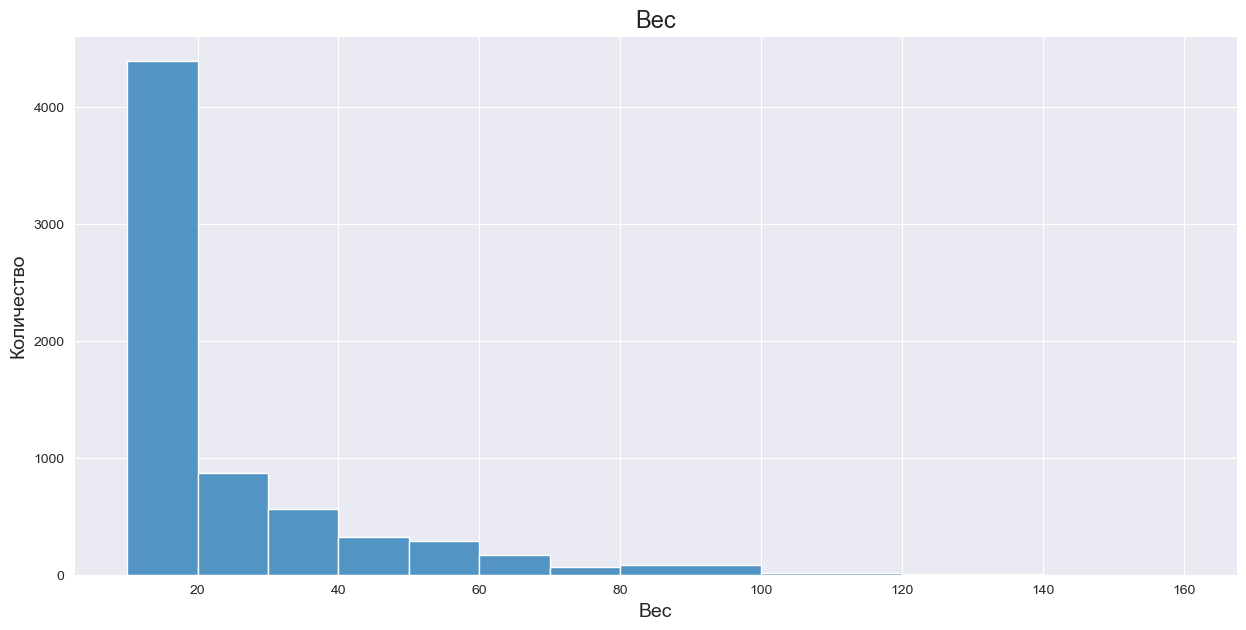

In [109]:
plt.figure(figsize=(15, 7))
plt.title('Вес', fontsize=17)
sns.set_style('darkgrid')
sns.histplot(data['goods_wght'], bins=[10,20,30,40,50,60,70,80,100,120,140,160])
plt.ylabel('Количество', fontsize=14)
plt.xlabel('Вес', fontsize=14)
plt.grid(True);

**В наборе присутствуют товары с нулевым весом. Вполне возможно, что при заполнение могли не указать значения или данные выгрузилилсь не совсем корректно.Посмотрим на записи с нулевым весом**

In [110]:
cargotype_info['cargotype'] = cargotype_info['cargotype'].astype('int')

In [111]:
df_with_zero_w = data.query('goods_wght == 0')

In [112]:
df_with_zero_w.head(50)

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid,a,b,c,list_demensions,recomended_price_for_pack,selected_price_for_pack,recomended_length_for_pack,selected_length_for_pack,recomended_width_for_pack,selected_width_for_pack,recomended_height_for_pack,selected_height_for_pack,volume_sku,specific_weight
21620,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,c67f783f0901454a55318fc3be3b6421,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]",3.616713,35.0,30.0,35.0,38.0,25.0,7.40,15.00,0.00,NaN
21621,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,c67f783f0901454a55318fc3be3b6421,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]",3.616713,35.0,30.0,35.0,38.0,25.0,7.40,15.00,0.00,NaN
21622,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,c67f783f0901454a55318fc3be3b6421,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]",3.616713,35.0,30.0,35.0,38.0,25.0,7.40,15.00,0.00,NaN
21623,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,c67f783f0901454a55318fc3be3b6421,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]",3.616713,35.0,30.0,35.0,38.0,25.0,7.40,15.00,0.00,NaN
21624,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,c67f783f0901454a55318fc3be3b6421,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]",3.616713,35.0,30.0,35.0,38.0,25.0,7.40,15.00,0.00,NaN
21625,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,5bc9da3b9043c46d999af2d3da73b4cd,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]",3.616713,35.0,30.0,35.0,38.0,25.0,7.40,15.00,0.00,NaN
21626,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,5bc9da3b9043c46d999af2d3da73b4cd,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]",3.616713,35.0,30.0,35.0,38.0,25.0,7.40,15.00,0.00,NaN
21627,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,5bc9da3b9043c46d999af2d3da73b4cd,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]",3.616713,35.0,30.0,35.0,38.0,25.0,7.40,15.00,0.00,NaN
21628,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,5bc9da3b9043c46d999af2d3da73b4cd,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]",3.616713,35.0,30.0,35.0,38.0,25.0,7.40,15.00,0.00,NaN
21629,0,3aba70cb5db6b8edc0f4a625cfc53b09,ymf,1,myc,ymf,13125,myc,0,8436,0.0,5bc9da3b9043c46d999af2d3da73b4cd,9f55de5c143d1b1ff2d6528e7207e5a4,84f001ac3455935bc2e16c0a72789da6,0.0,0.0,0.0,"[0.0, 0.0, 0.0]",3.616713,35.0,30.0,35.0,38.0,25.0,7.40,15.00,0.00,NaN


**Посмотрим на карготипы и их описание для записей с нулевым весом**

In [113]:
sku_cargotypes['cargotype'] = sku_cargotypes['cargotype'].astype('int') 

In [114]:
sku_cargotypes[sku_cargotypes['sku'].isin(df_with_zero_w['sku'].unique())].merge(cargotype_info[cargotype_info['cargotype'].isin(sku_cargotypes[sku_cargotypes['sku'].isin(df_with_zero_w['sku'].unique())]['cargotype'].unique().tolist())],
                                                                                 how='left', on='cargotype')

,sku,cargotype,description
0,9b353e6620dda2651a2a37f8c41e1ddc,292,Склад КГТ (крупногабаритный товар)
1,9b353e6620dda2651a2a37f8c41e1ddc,300,тяжеловесный и крупногабаритный
2,9b353e6620dda2651a2a37f8c41e1ddc,301,тяжеловесный и крупногабаритный 20кг
3,9b353e6620dda2651a2a37f8c41e1ddc,340,не требует упаковки
4,9b353e6620dda2651a2a37f8c41e1ddc,950,пачкается
5,45f4aaaa64cd6758896e6596fc151c6a,200,техника и электроника
6,45f4aaaa64cd6758896e6596fc151c6a,290,Склад МГТ (малогабаритный товар)
7,45f4aaaa64cd6758896e6596fc151c6a,410,опасный Авиа
8,45f4aaaa64cd6758896e6596fc151c6a,640,электроника
9,45f4aaaa64cd6758896e6596fc151c6a,691,цена средняя


**Такие позиции не могут иметь нулевой вес, а так же ухудшат качество работы модели, и потому будут удалены из набора данных.**

In [115]:
data = data[data['goods_wght'] != 0]

In [116]:
df_with_large_w = data.query('goods_wght >= 60')

**Посмотрим на записи с большим весом**

In [117]:
df_with_large_w.head(5)

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid,a,b,c,list_demensions,recomended_price_for_pack,selected_price_for_pack,recomended_length_for_pack,selected_length_for_pack,recomended_width_for_pack,selected_width_for_pack,recomended_height_for_pack,selected_height_for_pack,volume_sku,specific_weight
101394,0,4d77ddebaab95963bd4dda166e8f2c98,stretch,1,nonpack,stretch,0,nonpack,662338,0,60.0,db249e2acc4aa4011f3708e152589e88,08db02c4b186b8481663a091b8d587c6,0658e5b2ff316bdaf3df5448d61b00a2,61.0,61.0,178.0,"[61.0, 61.0, 178.0]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,662338.0,0.000091
221029,2,40eb240fc7ab31423dd973559d302142,nonpack,1,nonpack,nonpack,0,nonpack,812928,0,62.0,d91c85cc0e935e840c666906623bc990,4698b499cb199a121170f0c554ee7afc,39f1daabfa40bf491b7eaead1c7ff760,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
221329,2,e6da4200896381cf832e038506f16a3c,nonpack,1,nonpack,nonpack,0,nonpack,812328,0,71.0,847e6e4773014897c2a1af17e83513ba,4698b499cb199a121170f0c554ee7afc,16211c54e166d4227ccbdc081a117c52,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
223534,2,6b091b24c9153239df72b5845eabda56,nonpack,1,nonpack,nonpack,0,nonpack,760320,0,69.0,e8bab2fa947cd5dac52c04ea43a501a0,99fc1811e8e45ed8bd8a8f1d892daa4f,b69f0a497b8091f78a41b286fd433ae5,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
223899,2,1a32cff69ed7631e0e162ba6ed9b8d64,nonpack,1,nonpack,nonpack,0,nonpack,500000,0,70.0,6d2ac4d7c247d1eb2ac0370926eda881,99fc1811e8e45ed8bd8a8f1d892daa4f,6cab19196a115e075f4b005cd397781c,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [118]:
print('Количетсво записей с весом больше 60 -',len(df_with_large_w))

Количетсво записей с весом больше 60 - 326


In [119]:
print('Типы упаковок для большого веса', df_with_large_w['selected_cartontype'].unique())

Типы упаковок для большого веса ['stretch' 'nonpack']


**Типы 'stretch' 'nonpack' в записях с ввесом больше 60 могут использоваться для крупногабаритных товаров или товаров в надженой заводской упаковке.**

**Посмотрим на карготипы и их описание для записей с нулевым весом**

In [120]:
sku_cargotypes[sku_cargotypes['sku'].isin(df_with_large_w['sku'].unique())].merge(cargotype_info[cargotype_info['cargotype'].isin(sku_cargotypes[sku_cargotypes['sku'].isin(df_with_large_w['sku'].unique())]['cargotype'].unique().tolist())],
                                                                                 how='left', on='cargotype')

,sku,cargotype,description
0,844e666e2284ec15fa001becf0b8abb7,200,техника и электроника
1,844e666e2284ec15fa001becf0b8abb7,292,Склад КГТ (крупногабаритный товар)
2,844e666e2284ec15fa001becf0b8abb7,300,тяжеловесный и крупногабаритный
3,844e666e2284ec15fa001becf0b8abb7,301,тяжеловесный и крупногабаритный 20кг
4,844e666e2284ec15fa001becf0b8abb7,302,тяжеловесный и крупногабаритный больше паллеты
5,844e666e2284ec15fa001becf0b8abb7,410,опасный Авиа
6,844e666e2284ec15fa001becf0b8abb7,672,товары для спорта и отдыха
7,844e666e2284ec15fa001becf0b8abb7,692,цена высокая
8,b2fb2ed104fb6e472d3034438c116bdd,200,техника и электроника
9,b2fb2ed104fb6e472d3034438c116bdd,292,Склад КГТ (крупногабаритный товар)


**Такие записи не будут являтся аномалией, и поэтому будут важны в обучении модели.**

In [121]:
del df_with_zero_w, df_with_large_w

## Целевой признак

**Изучим как часто встречается каждый из таргетов в датасете**

In [122]:
data['selected_cartontype'].value_counts()

myb        55928
myc        48837
nonpack    30361
ymc        27149
myd        24663
ymg        23610
mya        20400
ymf        19244
ymw        19171
yma        15777
yme        12685
stretch    12437
mye         9717
yml         3280
myf         1350
ymx          802
ymb            2
Name: selected_cartontype, dtype: int64

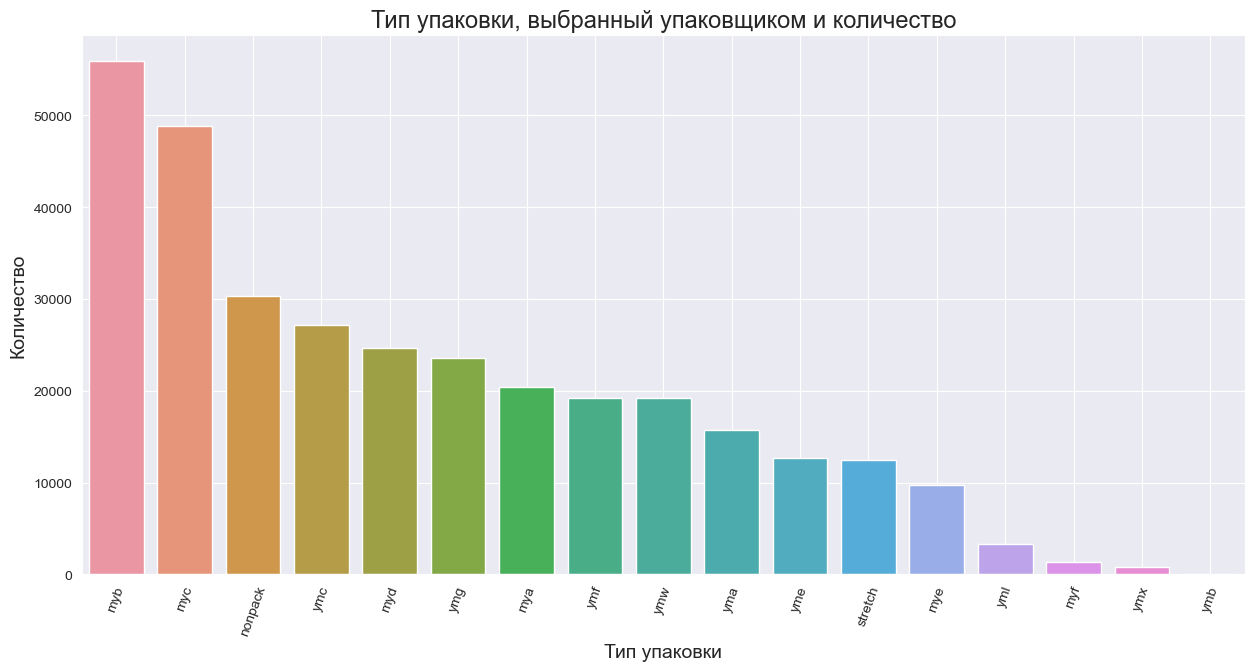

In [123]:
plt.figure(figsize=(15, 7))
plt.title('Тип упаковки, выбранный упаковщиком и количество', fontsize=17)
sns.set_style('darkgrid')
sns.barplot(data=data['selected_cartontype'].value_counts().reset_index(),
            x='index',
            y='selected_cartontype')
plt.ylabel('Количество', fontsize=14)
plt.xlabel('Тип упаковки', fontsize=14)
plt.xticks(rotation=70)
plt.grid(True);

**Есть популярные упоковки, а есть упоковки, которые встречаются крайне редко, например YMB встречается только 2 раза**

**Изучим, как часто бывают ситуации, что для одного sku предусматривают разные типы упаковок**

In [124]:
selected_carton_sku = data.groupby(['sku', 'selected_cartontype'])['sku'].agg('count')
selected_carton_sku

sku                               selected_cartontype
00001dba9dfe01a550c23064c2b8e96f  nonpack                1
000198cfae123aef536f2fcf0b104049  yma                    1
0003da69535758c817b78b64da05aae0  ymc                    2
                                  yme                    1
                                  ymg                    3
                                                        ..
ffff026f5a46a375634c460083adf3dd  myc                    3
                                  yma                    1
                                  ymc                    1
                                  ymf                    1
ffff122050818cd7a35d0aa3d40ffd8c  myc                    1
Name: sku, Length: 142199, dtype: int64

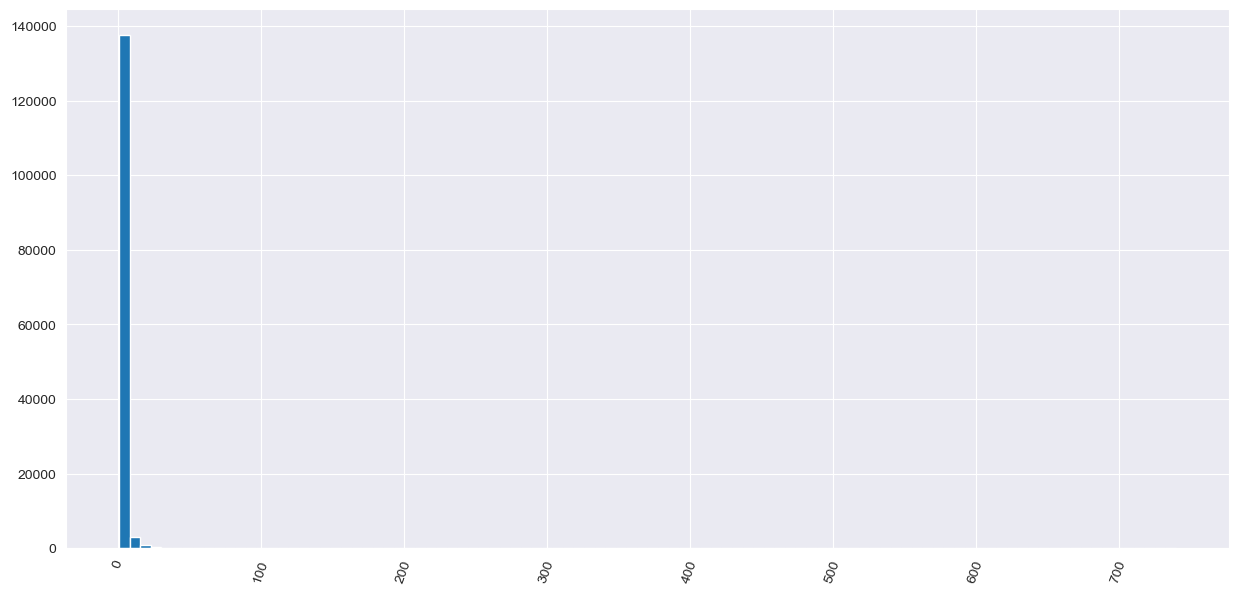

In [125]:
plt.figure(figsize=(15, 7))
sns.set_style('darkgrid')
plt.hist(selected_carton_sku, 100)
plt.xticks(rotation=70)
plt.grid(True);

**Очень много случаев, что конркетная коробка под конкретный товар исполась только один раз**

**Сведём в одну таблицу сведения по каждому товару и упаковкам к ним**

In [126]:
df_sel_cart_sku = (pd.DataFrame(selected_carton_sku).rename(columns={'sku':'count_sku_cart'}).reset_index(drop=False))

In [127]:
df_count_sku = (pd.DataFrame(data.groupby('sku')['sku'].agg('count')).rename(columns={'sku': 'count_sku_all'}).reset_index(drop=False))

In [128]:
df_sel_cart_sku = df_sel_cart_sku.merge(df_count_sku, how='left', on='sku')

**Добавим долю каждой упаковки в общем типе упаковок для данного товара.**

In [129]:
df_sel_cart_sku['perc_carton'] = df_sel_cart_sku['count_sku_cart'] / df_sel_cart_sku['count_sku_all']

In [130]:
df_sel_cart_sku

,sku,selected_cartontype,count_sku_cart,count_sku_all,perc_carton
0,00001dba9dfe01a550c23064c2b8e96f,nonpack,1,1,1.000000
1,000198cfae123aef536f2fcf0b104049,yma,1,1,1.000000
2,0003da69535758c817b78b64da05aae0,ymc,2,7,0.285714
3,0003da69535758c817b78b64da05aae0,yme,1,7,0.142857
4,0003da69535758c817b78b64da05aae0,ymg,3,7,0.428571
...,...,...,...,...,...
142194,ffff026f5a46a375634c460083adf3dd,myc,3,14,0.214286
142195,ffff026f5a46a375634c460083adf3dd,yma,1,14,0.071429
142196,ffff026f5a46a375634c460083adf3dd,ymc,1,14,0.071429
142197,ffff026f5a46a375634c460083adf3dd,ymf,1,14,0.071429


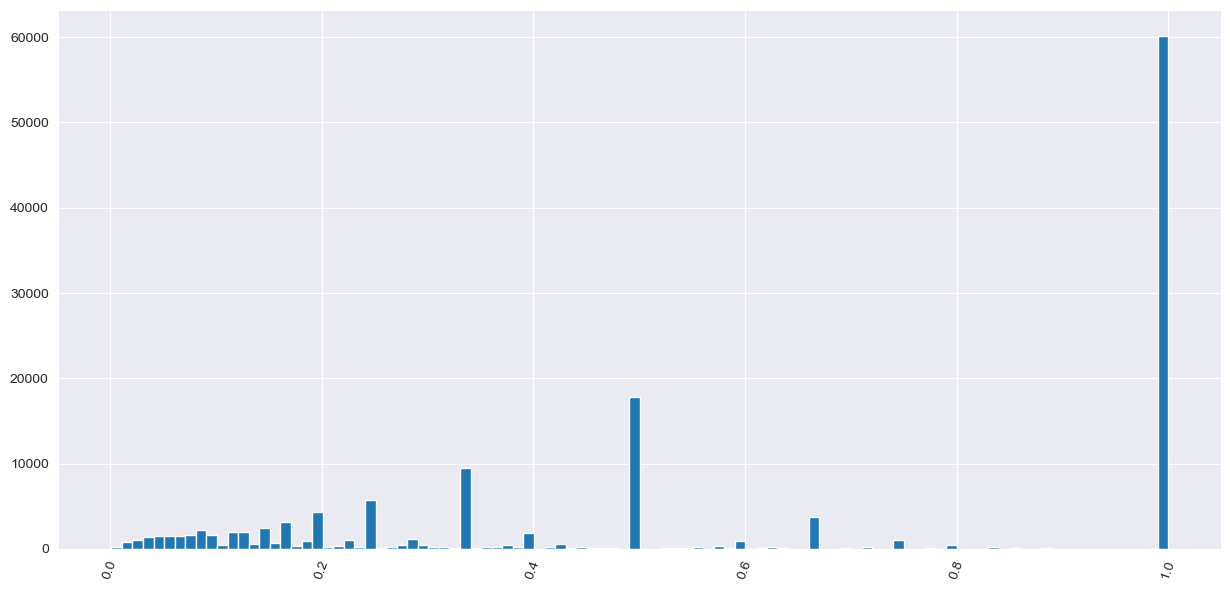

In [131]:
plt.figure(figsize=(15, 7))
sns.set_style('darkgrid')
plt.hist(df_sel_cart_sku['perc_carton'], 100)
plt.xticks(rotation=70)
plt.grid(True);

**Как видим для большинства товаров упаковщики используют один и тот же тип товаров, однако есть те товары, для которых разные упаковщики берут разные коробки это может быть связано как с личными предпочтениями упаковщика, так и с тем, что в одну упаковку, могут класть несколько товаров, чтобы оптимально выбрать наиболее подходящую коробку добавим в датасет размеры и объём коробок.**

**Посмотрим размеры данных коробок и прицепим сюда объём**

In [132]:
carton = pd.read_csv(PATH_CARTON)
carton.head()

,CARTONTYPE,LENGTH,WIDTH,HEIGHT,DISPLAYRFPACK
0,YMA,24.7,15.0,10.0,1
1,YMC,30.0,20.0,15.0,1
2,YME,30.0,30.0,44.5,1
3,YMF,35.0,25.0,15.0,1
4,YMG,44.7,30.0,20.0,1


**Добавим столбец объёма**

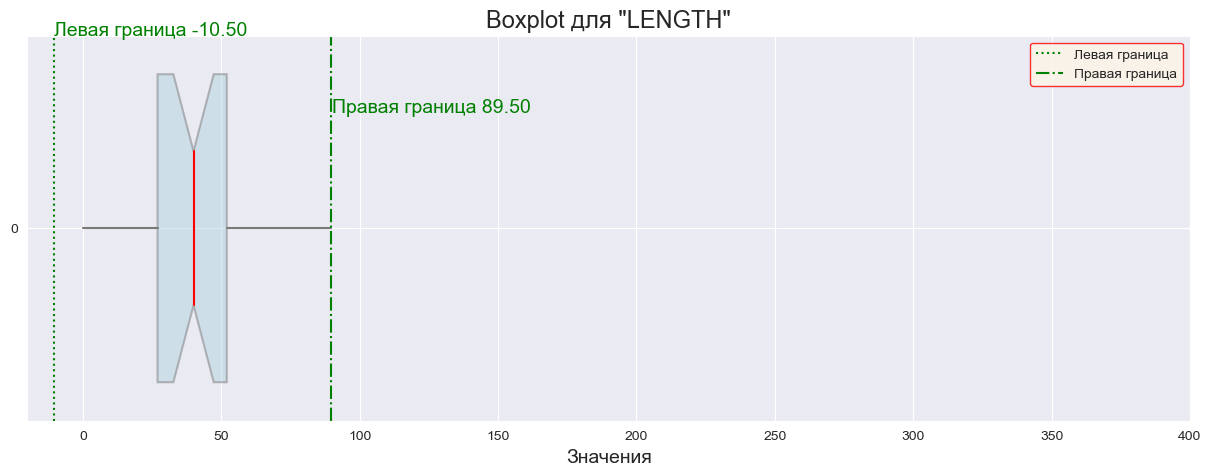

In [133]:
plot_boxplot(carton, 'LENGTH', -20 , 400)

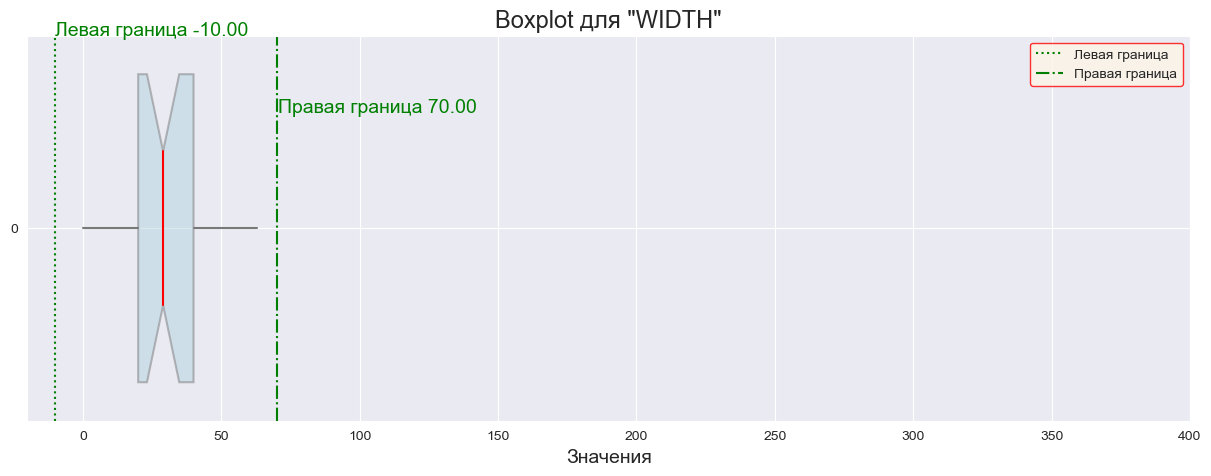

In [134]:
plot_boxplot(carton, 'WIDTH', -20, 400)

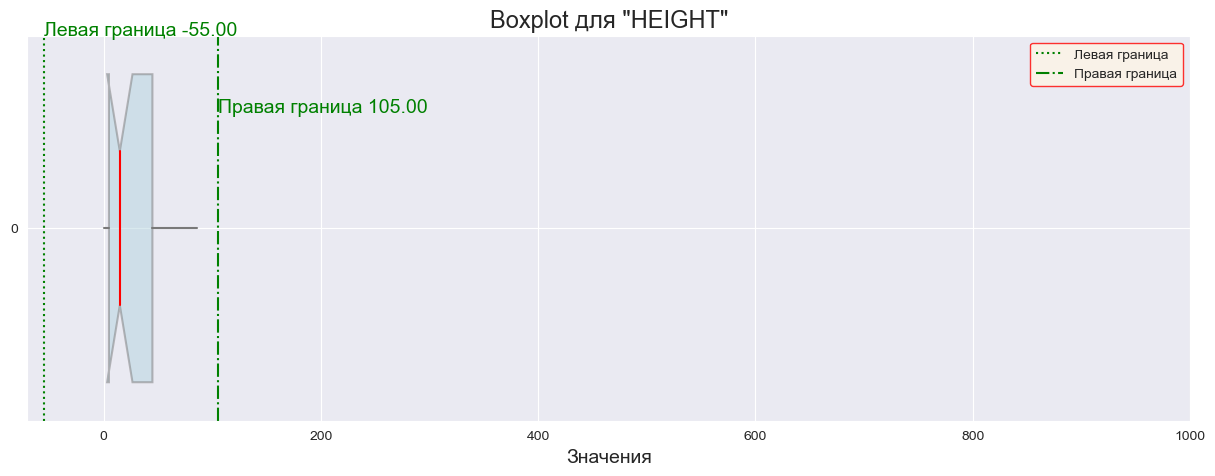

In [135]:
plot_boxplot(carton, 'HEIGHT', -70, 1000)

In [136]:
carton['volume'] = carton['LENGTH'] * carton['WIDTH'] * carton['HEIGHT']

**На графиках видно, что в данных присутствуют аномалии, для улучшения качества модели в дальннейшем от них следует избавится.**

In [137]:
carton = carton.rename(columns={'CARTONTYPE': 'selected_cartontype'})

In [138]:
carton = str_to_lower(carton)

In [139]:
carton

,selected_cartontype,LENGTH,WIDTH,HEIGHT,DISPLAYRFPACK,volume
0,yma,24.7,15.0,10.00,1,3705.000
1,ymc,30.0,20.0,15.00,1,9000.000
2,yme,30.0,30.0,44.50,1,40050.000
3,ymf,35.0,25.0,15.00,1,13125.000
4,ymg,44.7,30.0,20.00,1,26820.000
5,ymh,42.0,20.0,86.00,0,72240.000
6,ymj,50.0,29.0,48.00,0,69600.000
7,ksd,0.0,0.0,0.00,0,0.000
8,yml,60.0,40.0,45.00,1,108000.000
9,ymn,60.0,60.0,40.00,0,144000.000


**Добавим столбец с объёмом в таблицу с соотношением коробки и sku**

In [140]:
df_sel_cart_sku = df_sel_cart_sku.merge(carton[['selected_cartontype', 'volume']], how='left', on='selected_cartontype')

In [141]:
df_sel_cart_sku.head()

,sku,selected_cartontype,count_sku_cart,count_sku_all,perc_carton,volume
0,00001dba9dfe01a550c23064c2b8e96f,nonpack,1,1,1.000000,0.0
1,000198cfae123aef536f2fcf0b104049,yma,1,1,1.000000,3705.0
2,0003da69535758c817b78b64da05aae0,ymc,2,7,0.285714,9000.0
3,0003da69535758c817b78b64da05aae0,yme,1,7,0.142857,40050.0
4,0003da69535758c817b78b64da05aae0,ymg,3,7,0.428571,26820.0
